# pca

In [18]:
# ================================
# PCA (Excel, Jupyter) — EN labels, stable plots, KMO-selection, pretty outputs
# + Tables: component matrix, assigned variables (threshold), communalities
# ================================

## -----------------------------------------------------------
## >>> EDIT HERE: PATHS, VARIABLES, THRESHOLDS (single place)
## -----------------------------------------------------------
base_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"   # <<< change if needed
excel_file <- file.path(base_dir, "Sophia_Data.xls")                      # <<< exact Excel filename
sheet_name <- NULL                                                        # <<< e.g. "Sheet1"; NULL = first
out_dir    <- file.path(base_dir, "PCA_sup")                         # <<< output folder


# PCA_sup_ohnedoc
# PCA_sup_mitdoc
#============================
# PCA_alles_ohnewassertemp
# PCA_alles_wassertemp
# PCA_ohneCO2_ohnewassertemp
# PCA_ohneCO2_mitwassertemp
# PCA_ohneKohlenstoff_ohnewassertemp
# PCA_ohneKohlenstoff_mitwassertemp
# PCA_ohneKohlenstoff_mitwassertemp_comprot




VARS <- c(  # <<< variables to consider
#  "average_DOC_sample",
# "BDOC_pct",
#  "CO2_Flux",
  "Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "Temp_C",
#    "comp.prot",
    "Hight_sl",
#    "SpCond_uSpercm_korr",
    

  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5",
    "Air_temp"
)

# "average_DOC_sample","BDOC_pct","CO2_Flux",

KMO_TARGET  <- 0.70   # <<< set your KMO target here (e.g., 0.50, 0.60, 0.70 …)
LOAD_THRESH <- 0.50   # <<< absolute loading cutoff for "assigned variables" tables

## -----------------------------------------------------------
## Packages
## -----------------------------------------------------------
req <- c("readxl","psych","dplyr","ggplot2","corrplot","tibble",
         "knitr","GPArotation","ggrepel","Matrix","factoextra","grid")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install) > 0) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))




# ========= Pretty labels (global) =========
PRETTY_NAMES <- c(
  "Chlorophyll_ugperL" = "chlorophyll",
  "ODO_mgperL"         = "oxygen",
  "BGA_PC_ugperL"      = "phycocyanin",
  "Turbidity_FNU"      = "turbidity",
  "pH"                 = "pH",
  "Temp_C"             = "water temp.",
  "Hight_sl"           = "height amsl",   # <— anpassen, falls Spaltenname anders ist
  "comp.prot"          = "comp. prot",
  "pctComp.2"          = "comp.2",
  "pctComp.3"          = "comp.3",
  "pctComp.4"          = "comp.4",
  "Air_temp"           = "air temp.",
  # Supplementary
  "average_DOC_sample" = "DOC",
  "BDOC_pct"           = "BDOC",
  "CO2_Flux"           = "CO2 Flux"
)

pretty_name <- function(x){
  x <- as.character(x)
  i <- match(x, names(PRETTY_NAMES))
  ifelse(is.na(i), x, PRETTY_NAMES[i])
}

# praktischer Helfer: DataFrame-Spalten „hübsch“ anzeigen (nur für Ausgabe!)
pretty_colnames <- function(df){
  colnames(df) <- pretty_name(colnames(df)); df
}











## -----------------------------------------------------------
## Helpers (no HTML)
## -----------------------------------------------------------
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
graphics.off()
show_h1 <- function(txt){ cat("\n\n==== ", txt, " ====\n", sep="") }
note    <- function(txt){  cat("Note: ", txt, "\n", sep = "") }
warnln  <- function(txt){  cat("⚠️  ", txt, "\n", sep = "") }
okln    <- function(txt){  cat("✅ ", txt, "\n", sep = "") }
show_tbl<- function(df, caption=NULL){ print(knitr::kable(df, format="simple", caption=caption, align="l")) }

to_numeric_df <- function(df){
  out <- df
  out[] <- lapply(out, function(x){
    if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
    else { suppressWarnings(as.numeric(x)) }
  })
  out
}

# stable plotting: show first, then save
plot_save_show_gg <- function(p, file, width_cm=18, height_cm=12, dpi=300){
  print(p)  # show in notebook
  ggplot2::ggsave(filename = file, plot = p, width = width_cm, height = height_cm, units = "cm", dpi = dpi)
}
plot_save_show_base <- function(plot_expr, file, width_px=1800, height_px=1400, res=180){
  graphics.off(); par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # show
  png(filename = file, width = width_px, height = height_px, res = res)
  par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # save
  dev.off()
  invisible(NULL)
}

## -----------------------------------------------------------
## Load data
## -----------------------------------------------------------
stopifnot("Excel file not found." = file.exists(excel_file))
sheets <- readxl::excel_sheets(excel_file); if(is.null(sheet_name)) sheet_name <- sheets[1]
raw <- read_excel(excel_file, sheet = sheet_name)

if(!all(VARS %in% names(raw))){
  miss <- setdiff(VARS, names(raw))
  stop(paste0("Missing variables in '", sheet_name, "': ", paste(miss, collapse=", ")))
}

dat <- raw[, VARS, drop = FALSE]
dat_num <- to_numeric_df(dat)

n0 <- nrow(dat_num)
dat_cc <- na.omit(dat_num)
n_used <- nrow(dat_cc); n_removed <- n0 - n_used

show_h1("Data overview")
show_tbl(data.frame(Total_rows=n0, Complete_rows=n_used, Removed_due_to_NA=n_removed),
         "Row counts")

## -----------------------------------------------------------
## KMO-driven variable selection (stabilises PCA)
## -----------------------------------------------------------
kmo_for <- function(df, cols){
  X <- df[, cols, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]
  if(nrow(X) < 10 || ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  sds <- sapply(X, sd, na.rm=TRUE); if(any(sds<=0 | !is.finite(sds))) X <- X[, sds>0 & is.finite(sds), drop=FALSE]
  if(ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  R <- suppressWarnings(cor(X, use="complete.obs"))
  ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
  if(min(ev) <= 1e-8) R <- as.matrix(Matrix::nearPD(R, corr=TRUE)$mat)
  km <- tryCatch(psych::KMO(R), error=function(e) NULL)
  if(is.null(km)) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=R))
  list(ok=TRUE, KMO=as.numeric(km$MSA), MSAi=km$MSAi, R=R)
}
round_ok <- function(x) !is.na(x) && (round(x,2) >= KMO_TARGET)

vars_all <- intersect(VARS, colnames(dat_cc))
comp_in  <- intersect(grep("^pctComp\\.", vars_all, value=TRUE), vars_all)
cur <- vars_all
history <- tibble::tibble(Step=0L, p=length(cur), Removed="–", Set="start", KMO=NA_real_)
res <- kmo_for(dat_cc, cur); history$KMO[1] <- res$KMO

best_set <- cur; best_res <- res
if(length(comp_in) > 0){
  for(k in 1:length(comp_in)){
    cmb <- combn(comp_in, k, simplify=FALSE)
    evals <- lapply(cmb, function(rem){
      cols <- setdiff(vars_all, rem)
      list(rem=rem, out=kmo_for(dat_cc, cols), cols=cols)
    })
    ok <- Filter(function(z) isTRUE(z$out$ok), evals)
    if(length(ok)){
      ks <- sapply(ok, function(z) z$out$KMO); imax <- which.max(ks); cand <- ok[[imax]]
      history <- dplyr::add_row(history, Step=nrow(history), p=length(cand$cols),
                                Removed=paste(cand$rem, collapse=", "), Set="only_pctComp", KMO=cand$out$KMO)
      if(round_ok(cand$out$KMO)){ best_set <- cand$cols; best_res <- cand$out; break }
      if(is.na(best_res$KMO) || cand$out$KMO > best_res$KMO){ best_set <- cand$cols; best_res <- cand$out }
    }
  }
  cur <- best_set; res <- best_res
}
if(!round_ok(res$KMO)){
  improved <- TRUE
  while(!round_ok(res$KMO) && improved && length(cur) > 3){
    improved <- FALSE
    trials <- lapply(seq_along(cur), function(i){
      cand <- cur[-i]; out <- kmo_for(dat_cc, cand)
      list(var=cur[i], KMO=out$KMO, ok=out$ok, cols=cand, out=out)
    })
    trials <- Filter(function(z) isTRUE(z$ok), trials); if(length(trials)==0) break
    imax <- which.max(sapply(trials, `[[`, "KMO")); pick <- trials[[imax]]
    if(is.na(res$KMO) || (pick$KMO > res$KMO + 1e-4)){
      history <- dplyr::add_row(history, Step=nrow(history), p=length(pick$cols),
                                Removed=pick$var, Set="greedy_rest", KMO=pick$KMO)
      cur <- pick$cols; res <- pick$out; improved <- TRUE
    } else break
  }
}
SEL_VARS <- cur
show_h1("KMO-driven selection")
show_tbl(history, "KMO path (steps)")
write.csv(history, file.path(out_dir, "KMO_path_selection.csv"), row.names=FALSE)
kmo_df <- data.frame(Variable=names(res$MSAi), MSA=round(as.numeric(res$MSAi),3)) %>% dplyr::arrange(MSA)
show_tbl(kmo_df, "MSA per variable (ascending)")
write.csv(kmo_df, file.path(out_dir, "KMO_MSA_final.csv"), row.names=FALSE)

## -----------------------------------------------------------
## Correlation & eigenvalues (selected vars) + correlation triangle
## -----------------------------------------------------------
dat_cc_sel <- dat_cc[, SEL_VARS, drop=FALSE]
R    <- cor(dat_cc_sel, use = "pairwise.complete.obs")
ev_R <- eigen(R, symmetric=TRUE, only.values=TRUE)$values
write.csv(round(R,3),    file.path(out_dir,"01_Correlation_matrix.csv"))
write.csv(round(ev_R,6), file.path(out_dir,"02_Eigenvalues_of_R.csv"), row.names=FALSE)

show_h1("Correlation matrix & eigenvalues")
show_tbl(round(R,3), "Correlation matrix (Pearson)")
ev_tbl <- data.frame(Component=paste0("EV", seq_along(ev_R)), Eigenvalue=round(ev_R,4))
show_tbl(ev_tbl, "Eigenvalues of correlation matrix")

# Pretty block: Matrix definiteness (display + save)
classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
  thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
  pd  <- all(ev >  thr, na.rm = TRUE)
  psd <- all(ev >= -thr, na.rm = TRUE)
  sing <- psd && any(ev <  thr, na.rm = TRUE)
  status <- if(pd) "positive definite" else if(sing) "positive semidefinite (singular)" else if(psd) "positive semidefinite" else "NOT positive semidefinite"
  list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
}
pretty_definiteness <- function(R, ev, out_dir){
  det_R <- det(R)
  kap   <- tryCatch(kappa(R), error=function(e) NA_real_)
  rcond <- if(is.finite(kap)) 1/kap else NA_real_
  dres  <- classify_definiteness(ev)
  show_h1("Definiteness of correlation matrix (pretty)")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  if(dres$status == "positive definite"){
    okln("Matrix is positive definite → PCA is numerically stable.")
  } else if(dres$status == "positive semidefinite (singular)"){
    warnln("Matrix is only positive semidefinite (singular) → near-linear dependencies.")
  } else if(dres$status == "positive semidefinite"){
    warnln("Matrix is positive semidefinite (not strictly PD) → caution with inversions.")
  } else {
    warnln("Matrix is NOT positive semidefinite → negative eigenvalues present.")
  }
  con <- file.path(out_dir, "01c_Definiteness_pretty.txt")
  sink(con)
  cat("==== Correlation Matrix Definiteness ====\n")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  sink()
  invisible(dres)
}
dres <- pretty_definiteness(R, ev_R, out_dir)

# Correlation triangle — show & save
show_h1("Correlation triangle (upper)")
plot_save_show_base(
  corrplot::corrplot(R, type="upper", order="hclust", tl.col="black",
                     addCoef.col="black", number.cex=0.6),
  file = file.path(out_dir,"01b_CorrTriangle.png"),
  width_px = 1800, height_px = 1600, res = 200
)

## -----------------------------------------------------------
## Component selection criteria (PCA only)
## -----------------------------------------------------------
# 1) Kaiser (EV > 1)
n_kaiser <- sum(ev_R > 1)
kaiser_tbl <- data.frame(
  Component = seq_along(ev_R),
  Eigenvalue = round(ev_R,4),
  Kaiser_gt1 = ev_R > 1
)
show_h1("Criterion 1 — Kaiser (eigenvalue > 1)")
show_tbl(kaiser_tbl, "Kaiser rule table")
write.csv(kaiser_tbl, file.path(out_dir, "20_Components_Kaiser.csv"), row.names=FALSE)



      
# 2) Scree plot mit Eigenwert-Beschriftung + Kaiser-Regel (EV > 1 rot)
show_h1("Criterion 2 — Scree plot")
scree_df <- data.frame(
  Component = seq_along(ev_R),
  Eigenvalue = ev_R,
  Kaiser = ev_R > 1
)

p_scree <- ggplot(scree_df, aes(Component, Eigenvalue)) +
  geom_point(aes(color = Kaiser), size = 3) +
  geom_line() +
  geom_hline(yintercept=1, linetype="dashed", colour="red") +
  geom_text(aes(label = round(Eigenvalue,2), 
                fontface = ifelse(Kaiser,"bold","plain"),
                color = Kaiser),
            vjust = -0.8, size = 3.5, show.legend = FALSE) +
  scale_color_manual(values = c("black","red")) +
  scale_y_continuous(
    breaks = c(pretty(ev_R), 1),      # normale Achsenwerte + 1
    labels = function(x) ifelse(x==1,"1 (Kaiser)",x)
  ) +
  labs(
    title    = "Scree plot (eigenvalues of correlation matrix)",
    subtitle = "red dashed line = Kaiser criterion (EV = 1)",
    x = "Component",
    y = "Eigenvalue"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "none")

plot_save_show_gg(p_scree, file.path(out_dir,"21_Screeplot.png"))




      
      
# 3) Parallel analysis (PCA)
#show_h1("Criterion 3 — Parallel analysis (PCA)")
#graphics.off(); par(mfrow=c(1,1))
#fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
#png(file.path(out_dir,"22_Parallel_Analysis.png"), width=1800, height=1200, res=180)
#par(mfrow=c(1,1))
#fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
#dev.off()
#pa_res <- fa.parallel(dat_cc_sel, fm="pc", fa="pc", plot=FALSE)
#n_pa <- sum(pa_res$pc.values > pa_res$pc.sim)
#cat("Results → PA: ", n_pa, " components | Kaiser: ", n_kaiser, " components.\n", sep="")

# --------- Criterion 3 — Parallel analysis (PCA) ---------
show_h1("Criterion 3 — Parallel analysis (PCA)")
graphics.off(); par(mfrow=c(1,1))

# 1) Ergebnisse berechnen (ohne Plot) und speichern
pa_res <- psych::fa.parallel(dat_cc_sel, fa = "pc", plot = FALSE)

# 2) Plot anzeigen UND als PNG speichern
#    (Plot entsteht nur mit plot=TRUE innerhalb des png()-Kontexts)
try({
  png(file.path(out_dir, "22_Parallel_Analysis.png"), width = 1800, height = 1200, res = 180)
  par(mfrow=c(1,1))
  psych::fa.parallel(dat_cc_sel, fa = "pc", plot = TRUE, main = "Parallel analysis (PCA)")
  dev.off()
}, silent = TRUE)

# 3) Anzahl Komponenten nach PA bestimmen
n_pa <- sum(pa_res$pc.values > pa_res$pc.sim)
cat("Results → PA: ", n_pa, " components | (PCA mode)\n", sep = "")



      
# Final choice: Kaiser
ncomp <- max(1, n_kaiser)
show_h1("Final number of components (chosen: Kaiser)")
cat("ncomp = ", ncomp, " (eigenvalue > 1)\n", sep="")

## -----------------------------------------------------------
## PCA (unrotated & varimax) + tables & biplots
## -----------------------------------------------------------
pca_unrot <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="none",   scores=TRUE, covar=FALSE)
pca_rot   <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="varimax", scores=TRUE, covar=FALSE)

# Variance tables
var_unrot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue = round(pca_unrot$values[seq_len(ncomp)],4),
  Proportion = round(pca_unrot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative = round(pca_unrot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — unrotated"); show_tbl(var_unrot)
write.csv(var_unrot, file.path(out_dir,"06_Variance_unrotated.csv"), row.names=FALSE)

var_rot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue_rot   = round(pca_rot$values[seq_len(ncomp)],4),
  Proportion_rot   = round(pca_rot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative_rot   = round(pca_rot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — varimax"); show_tbl(var_rot)
write.csv(var_rot, file.path(out_dir,"09_Variance_varimax.csv"), row.names=FALSE)

# Loadings & Communalities (unrotated)
load_unrot <- as.data.frame(unclass(pca_unrot$loadings))
commu_unrot<- data.frame(Variable=rownames(load_unrot),
                         Communality=round(rowSums(load_unrot^2),6))
write.csv(round(load_unrot,6), file.path(out_dir,"07_Loadings_unrotated.csv"))
write.csv(commu_unrot,       file.path(out_dir,"08_Communalities_unrotated.csv"), row.names=FALSE)

# Loadings (varimax) & Communalities
load_rot <- as.data.frame(unclass(pca_rot$loadings))
commu_rot<- data.frame(Variable=rownames(load_rot),
                       Communality_rot=round(rowSums(load_rot^2),6))
write.csv(round(load_rot,6), file.path(out_dir,"10_Loadings_varimax.csv"))
write.csv(commu_rot,       file.path(out_dir,"11_Communalities_varimax.csv"), row.names=FALSE)

## --------------------------
## TABLE 1: Component matrix (unrotated) — show & save
## --------------------------
show_h1(sprintf("Component matrix (unrotated) — %d components", ncomp))
comp_mat_unrot <- round(load_unrot[, seq_len(ncomp), drop=FALSE], 3)
colnames(comp_mat_unrot) <- paste0("Component ", seq_len(ncomp))
comp_mat_unrot <- cbind(Variable = rownames(comp_mat_unrot), comp_mat_unrot, row.names = NULL)
show_tbl(comp_mat_unrot, "Correlation coefficients (loadings) per component")
write.csv(comp_mat_unrot, file.path(out_dir,"30_ComponentMatrix_unrotated.csv"), row.names=FALSE)

## --------------------------
## TABLE 2: Assigned variables (unrotated, threshold)
## keep only the component with max |loading| per variable if >= LOAD_THRESH
## --------------------------
assign_by_threshold <- function(L, thr=0.5){
  A <- as.matrix(L[, seq_len(ncol(L)), drop=FALSE])
  rn <- rownames(A); cn <- colnames(A)
  sel <- apply(abs(A), 1, function(v){
    if(all(is.na(v))) return(rep(NA_real_, length(v)))
    j <- which.max(abs(v)); out <- rep(NA_real_, length(v))
    if(is.finite(v[j]) && abs(v[j]) >= thr) out[j] <- ifelse(is.na(v[j]), NA, v[j])
    out
  })
  B <- t(sel); colnames(B) <- cn; rownames(B) <- rn
  as.data.frame(B)
}
show_h1(sprintf("Assigned variables (unrotated) — |loading| ≥ %.2f", LOAD_THRESH))
ass_unrot <- assign_by_threshold(load_unrot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_unrot) <- paste0("Component ", seq_len(ncomp))
ass_unrot_out <- cbind(Variable=rownames(ass_unrot), round(ass_unrot,3), row.names=NULL)
show_tbl(ass_unrot_out, "Variables assigned to components (unrotated)")
write.csv(ass_unrot_out, file.path(out_dir,"31_AssignedVariables_unrotated_threshold.csv"), row.names=FALSE)
note(sprintf("Principal component analysis, with %d components extracted", ncomp))

## --------------------------
## TABLE 3: Communalities — Initial (=1) vs Extraction
## --------------------------
show_h1("Communalities — initial vs. extraction (unrotated)")
comm_tab <- data.frame(
  Standardised_variables = commu_unrot$Variable,
  Initial = 1.000000,
  Extraction = round(commu_unrot$Communality, 6)
)
show_tbl(comm_tab, "Communalities (PCA extraction)")
write.csv(comm_tab, file.path(out_dir,"32_Communalities_initial_extraction.csv"), row.names=FALSE)

## --------------------------
## TABLE 4: Assigned variables (varimax, threshold)
## --------------------------
show_h1(sprintf("Assigned variables (varimax) — |loading| ≥ %.2f", LOAD_THRESH))
ass_rot <- assign_by_threshold(load_rot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_rot) <- paste0("Component ", seq_len(ncomp))
ass_rot_out <- cbind(Variable=rownames(ass_rot), round(ass_rot,3), row.names=NULL)
show_tbl(ass_rot_out, "Variables assigned to components (varimax)")
write.csv(ass_rot_out, file.path(out_dir,"33_AssignedVariables_varimax_threshold.csv"), row.names=FALSE)

# Biplots (separate)
show_h1("Biplot — unrotated")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_unrot, main="Biplot — unrotated")),
  file = file.path(out_dir,"14_Biplot_unrotated.png"),
  width_px = 1800, height_px = 1400, res = 180
)
show_h1("Biplot — varimax")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_rot, main="Biplot — varimax")),
  file = file.path(out_dir,"15_Biplot_varimax.png"),
  width_px = 1800, height_px = 1400, res = 180
)

## -----------------------------------------------------------
## KMO / Bartlett on selected R (pretty display + save)
## -----------------------------------------------------------
kmo  <- tryCatch(KMO(R), error=function(e){ warnln(paste("KMO failed:", e$message)); NULL })
bart <- tryCatch(cortest.bartlett(R, n = nrow(dat_cc_sel)), error=function(e){ warnln(paste("Bartlett failed:", e$message)); NULL })
if(!is.null(kmo)){
  msa_tbl2 <- data.frame(Variable = colnames(R), MSA = round(kmo$MSAi,3))
  write.csv(msa_tbl2, file.path(out_dir,"03_MSA_per_variable.csv"), row.names=FALSE)
}
pretty_kmo_bartlett <- function(kmo_obj, bart_obj, out_dir){
  show_h1("KMO / Bartlett (after selection)")
  msa_overall <- if(!is.null(kmo_obj)) as.numeric(kmo_obj$MSA) else NA_real_
  p_bart      <- if(!is.null(bart_obj)) as.numeric(bart_obj$p.value) else NA_real_
  chi_bart    <- if(!is.null(bart_obj)) as.numeric(bart_obj$chisq) else NA_real_
  df_bart     <- if(!is.null(bart_obj)) as.integer(bart_obj$df) else NA_integer_
  kmo_ok  <- !is.na(msa_overall) && msa_overall >= KMO_TARGET
  kmo_good<- !is.na(msa_overall) && msa_overall >= 0.80
  bart_ok <- !is.na(p_bart) && p_bart < 0.05

  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  if(kmo_ok){
    okln(if(kmo_good) "KMO/MSA good." else "KMO/MSA adequate.")
  } else {
    warnln(paste0("KMO/MSA < ", KMO_TARGET, " — sampling adequacy questionable."))
  }

  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  if(bart_ok){
    okln("Bartlett p < 0.05 → factorability acceptable.")
  } else {
    warnln("Bartlett p ≥ 0.05 — correlations may be insufficient.")
  }

  con <- file.path(out_dir, "04b_KMO_Bartlett_pretty.txt")
  sink(con)
  cat("==== KMO / Bartlett (after selection) ====\n")
  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  cat(if(kmo_ok) "✅ " else "⚠️ ",
      if(kmo_good) "KMO/MSA good.\n" else if(kmo_ok) "KMO/MSA adequate.\n" else paste0("KMO/MSA < ", KMO_TARGET, " — questionable.\n"),
      sep="")
  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  cat(if(bart_ok) "✅ Bartlett p < 0.05 → factorability acceptable.\n"
      else "⚠️ Bartlett p ≥ 0.05 — insufficient correlations.\n")
  sink()
  note(paste0("Saved: ", con))
}
pretty_kmo_bartlett(kmo, bart, out_dir)

## -----------------------------------------------------------
## Compact summary
## -----------------------------------------------------------
sink(file.path(out_dir,"00_Summary.txt"))
cat("Component selection (PCA only): Kaiser(EV>1)=", n_kaiser, " | PA=", n_pa, "\n", sep="")
cat("Chosen (Kaiser): ncomp=", ncomp, "\n", sep="")
cat("Variables used: ", paste(SEL_VARS, collapse=", "), "\n", sep="")
cat("Complete cases: ", n_used, " (of ", n0, ")\n", sep="")
sink()

show_h1("Summary")
cat("Kaiser(EV>1): ", n_kaiser, " | PA: ", n_pa, " → chosen: ", ncomp, "\n", sep="")
cat("Outputs saved to: ", out_dir, "\n", sep="")




==== Data overview ====


Table: Row counts

Total_rows   Complete_rows   Removed_due_to_NA 
-----------  --------------  ------------------
57           41              16                


==== KMO-driven selection ====


Table: KMO path (steps)

Step   p    Removed                Set            KMO       
-----  ---  ---------------------  -------------  ----------
0      13   –                      start          0.4974332 
1      12   pctComp.5              only_pctComp   0.6509775 
2      11   pctComp.1, pctComp.5   only_pctComp   0.6962420 


Table: MSA per variable (ascending)

Variable             MSA   
-------------------  ------
pH                   0.205 
Temp_C               0.454 
Turbidity_FNU        0.516 
BGA_PC_ugperL        0.613 
Chlorophyll_ugperL   0.631 
pctComp.3            0.730 
pctComp.2            0.734 
pctComp.4            0.740 
ODO_mgperL           0.742 
Hight_sl             0.746 
Air_temp             0.925 


==== Correlation matrix & eigenvalues =

png 
  2

Results → PA: 2 components | (PCA mode)


==== Final number of components (chosen: Kaiser) ====
ncomp = 3 (eigenvalue > 1)


==== Variance explained — unrotated ====


      Component   Eigenvalue   Proportion   Cumulative 
----  ----------  -----------  -----------  -----------
PC1   PC1         5.2859       0.4805       0.4805     
PC2   PC2         1.6528       0.1503       0.6308     
PC3   PC3         1.1222       0.1020       0.7328     


==== Variance explained — varimax ====


      Component   Eigenvalue_rot   Proportion_rot   Cumulative_rot 
----  ----------  ---------------  ---------------  ---------------
RC1   PC1         5.2859           0.3451           0.3451         
RC2   PC2         1.6528           0.2521           0.5972         
RC3   PC3         1.1222           0.1356           0.7328         


==== Component matrix (unrotated) — 3 components ====


Table: Correlation coefficients (loadings) per component

Variable             Component 1   Component 2   Comp

# (scree analyses)



==== Scree break detection ====
Curvature elbow (k_elbow1): 9
Two-line elbow (k_elbow2):  2
Broken-stick (k_bs):        11
Kaiser (EV>1):              3
Parallel Analysis (k_pa):   2
→ Suggested #components:    2


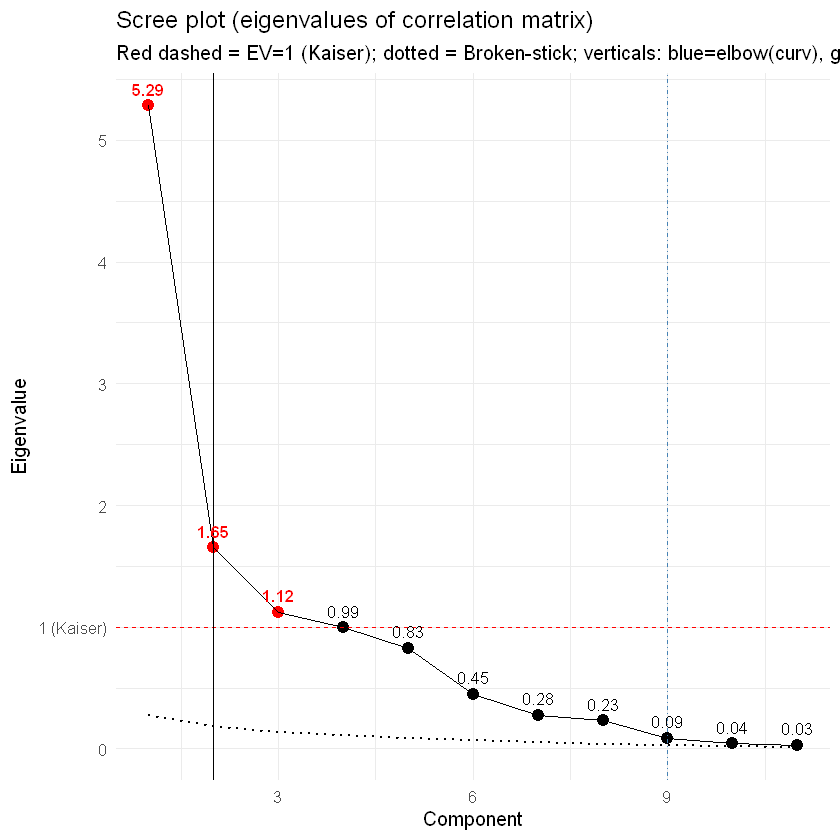

In [19]:
## ===== Scree "break" detection & annotated plot =====
## Place this block right after you define: ev_R <- eigen(R, ...)$values
## If you've already computed `n_pa` (Parallel Analysis), this block will pick it up.

library(ggplot2)

p <- length(ev_R)

# -- 1) Elbow by discrete curvature (second differences on log EV)
elbow_by_curvature <- function(ev){
  z  <- log(pmax(ev, .Machine$double.eps))
  # central second difference; interior points only (2..p-1)
  curv <- z[-c(1, p)] - 0.5*(z[-c(1, p-2)] + z[-c(3, p)])
  # pick index of max curvature and shift to original component index
  k <- which.max(curv) + 1
  return(k)
}

# -- 2) Elbow by two-line (piecewise) least squares
elbow_by_two_lines <- function(ev){
  x <- 1:length(ev)
  rss <- sapply(2:(length(ev)-1), function(k){
    fit1 <- lm(ev[1:k] ~ x[1:k])
    fit2 <- lm(ev[k:length(ev)] ~ x[k:length(ev)])
    sum(residuals(fit1)^2) + sum(residuals(fit2)^2)
  })
  which.min(rss) + 1
}

# -- 3) Broken-stick expected eigenvalues
broken_stick <- function(p){
  sapply(1:p, function(k) sum(1/(k:p))/p )
}

k_elbow1 <- elbow_by_curvature(ev_R)
k_elbow2 <- elbow_by_two_lines(ev_R)
bs_vals  <- broken_stick(p)
# Broken-stick rule of thumb: retain up to first index where ev < bs; retain = that index - 1
k_bs <- {
  idx <- which(ev_R < bs_vals)
  if(length(idx)==0) p else (min(idx)-1)
}

# Optional: if you computed PA earlier as n_pa, keep it; otherwise set to NA
k_pa <- if(exists("n_pa")) n_pa else NA_integer_

# Kaiser: EV > 1 (on correlation PCA)
k_kaiser <- sum(ev_R > 1)

# A simple consensus suggestion (you can adapt the logic):
# Use PA if available, else max of elbow estimates vs. Kaiser vs. broken-stick
k_suggest <- if(!is.na(k_pa)) k_pa else max(c(k_elbow1, k_elbow2, k_kaiser, k_bs), na.rm = TRUE)

cat("\n\n==== Scree break detection ====\n")
cat("Curvature elbow (k_elbow1): ", k_elbow1, "\n", sep="")
cat("Two-line elbow (k_elbow2):  ", k_elbow2, "\n", sep="")
cat("Broken-stick (k_bs):        ", k_bs, "\n", sep="")
cat("Kaiser (EV>1):              ", k_kaiser, "\n", sep="")
if(!is.na(k_pa)) cat("Parallel Analysis (k_pa):   ", k_pa, "\n", sep="")
cat("→ Suggested #components:    ", k_suggest, "\n", sep="")

# ---------- Annotated scree plot ----------
scree_df2 <- data.frame(
  Component  = seq_along(ev_R),
  Eigenvalue = ev_R,
  Kaiser     = ev_R > 1,
  BS         = bs_vals
)

# helper: vertical lines to draw
vlines <- unique(na.omit(c(k_elbow1, k_elbow2, k_bs, k_kaiser, k_pa, k_suggest)))
labs_v  <- setNames(
  nm = vlines,
  object = paste0("k=", vlines)
)

p_scree2 <- ggplot(scree_df2, aes(Component, Eigenvalue)) +
  geom_point(aes(color = Kaiser), size = 3) +
  geom_line() +
  # Kaiser line (EV=1)
  geom_hline(yintercept=1, linetype="dashed", colour="red") +
  # Broken-stick curve
  geom_line(aes(y = BS), linetype="dotted", linewidth=0.6) +
  # Elbow markers
  geom_vline(xintercept = k_elbow1, colour="steelblue", linetype="dotdash") +
  geom_vline(xintercept = k_elbow2, colour="darkgreen", linetype="longdash") +
  # PA (if present)
  { if(!is.na(k_pa)) geom_vline(xintercept = k_pa, colour="purple", linetype="twodash") } +
  # Suggested
  geom_vline(xintercept = k_suggest, colour="black", linetype="solid") +
  # labels on points: the exact eigenvalues
  geom_text(aes(label = round(Eigenvalue,2),
                fontface = ifelse(Kaiser,"bold","plain"),
                color = Kaiser),
            vjust = -0.8, size = 3.5, show.legend = FALSE) +
  scale_color_manual(values = c("black","red")) +
  scale_y_continuous(
    breaks = c(pretty(ev_R), 1),
    labels = function(x) ifelse(x==1,"1 (Kaiser)",x)
  ) +
  labs(
    title    = "Scree plot (eigenvalues of correlation matrix)",
    subtitle = paste0(
      "Red dashed = EV=1 (Kaiser); dotted = Broken-stick; verticals: ",
      "blue=elbow(curv), green=elbow(2-line), ",
      if(!is.na(k_pa)) "purple=PA, " else "",
      "black=suggested"
    ),
    x = "Component",
    y = "Eigenvalue"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "none")

plot_save_show_gg(p_scree2, file.path(out_dir,"21_Screeplot_annotated.png"))

# (Optional) Save a tiny text summary for your manuscript notes:
sink(file.path(out_dir, "21_Scree_Decision.txt"))
cat("Curvature elbow:", k_elbow1, "\n")
cat("Two-line elbow :", k_elbow2, "\n")
cat("Broken-stick   :", k_bs, "\n")
cat("Kaiser (EV>1)  :", k_kaiser, "\n")
if(!is.na(k_pa)) cat("Parallel Analysis:", k_pa, "\n")
cat("Suggested       :", k_suggest, "\n")
sink()




==== Criterion 2 — Scree plot (with consensus rules) ====


Table: Component number suggested by each rule

Rule                k  
------------------  ---
Kaiser (>1)         3  
Broken-stick        1  
Parallel analysis   2  
Max curvature       2  
Two-segment fit     2  
Consensus pick (median of rules) = 2  (range: 1–3)


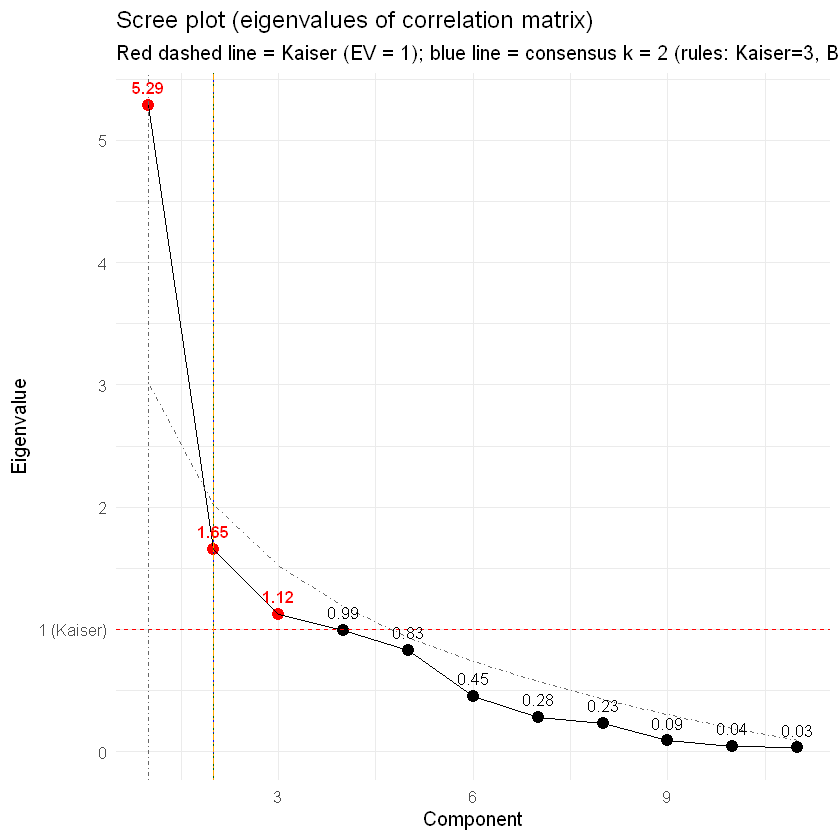

In [29]:
# ========= Scree: multiple rules + consensus pick =========
show_h1("Criterion 2 — Scree plot (with consensus rules)")
scree_df <- data.frame(Component = seq_along(ev_R), Eigenvalue = ev_R)

# -- Helper: broken–stick expected eigenvalues
broken_stick <- function(p){
  # expected value for the i-th component: sum_{k=i..p}(1/k)
  sapply(1:p, function(i) sum(1/(i:p)))
}

# -- Helper: "knee" by maximum curvature of the piecewise-linear curve
elbow_curvature <- function(x, y){
  # rescale to [0,1] for stability
  xr <- (x - min(x))/(max(x)-min(x)); yr <- (y - min(y))/(max(y)-min(y))
  # discrete second derivative (curvature proxy)
  k <- rep(NA_real_, length(x))
  for(i in 2:(length(x)-1)){
    k[i] <- abs(yr[i+1] - 2*yr[i] + yr[i-1])
  }
  which.max(k)  # index of largest curvature
}

# -- Helper: 2-segment piecewise linear fit (min RSS)
elbow_piecewise <- function(x, y){
  # try every split between 1 and p-1, fit two simple lines, pick minimal RSS
  best_k <- 1; best_rss <- Inf
  for(k in 1:(length(x)-1)){
    m1 <- lm(y[1:k] ~ x[1:k])
    m2 <- lm(y[(k+1):length(x)] ~ x[(k+1):length(x)])
    rss <- sum(residuals(m1)^2) + sum(residuals(m2)^2)
    if(rss < best_rss){ best_rss <- rss; best_k <- k }
  }
  best_k
}

p <- length(ev_R)
kaiser_k <- sum(ev_R > 1)                         # Kaiser > 1
bs_vals  <- broken_stick(p)
bs_k     <- max(which(ev_R > bs_vals), 1)         # last i where EV_i > BS_i
curv_k   <- elbow_curvature(seq_len(p), ev_R)     # curvature knee (index)
seg_k    <- elbow_piecewise(seq_len(p), ev_R)     # two-segment knee

# (Optional) Parallel analysis (you already compute pa_res above; reuse if present)
if(!exists("pa_res")) pa_res <- psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE)
pa_k <- sum(pa_res$pc.values > pa_res$pc.sim)

# Collect votes
rules <- data.frame(
  Rule = c("Kaiser (>1)", "Broken-stick", "Parallel analysis", "Max curvature", "Two-segment fit"),
  k    = c(kaiser_k, bs_k, pa_k, curv_k, seg_k),
  stringsAsFactors = FALSE
)

# Consensus: median of all rules (robust) + also report range
k_consensus <- max(1, round(median(rules$k)))
k_minmax    <- paste0(min(rules$k), "–", max(rules$k))

show_tbl(rules, "Component number suggested by each rule")
cat("Consensus pick (median of rules) = ", k_consensus, "  (range: ", k_minmax, ")\n", sep="")

# ---- Scree plot with decorations ----
scree_df$Kaiser <- ev_R > 1
p_scree <- ggplot(scree_df, aes(Component, Eigenvalue)) +
  geom_point(aes(color = Kaiser), size = 3) +
  geom_line() +
  geom_hline(yintercept = 1, linetype = "dashed", colour = "red") +
  # broken-stick curve
  geom_line(aes(y = bs_vals), linetype = "dotdash", colour = "grey40") +
  # vertical markers for each rule
  geom_vline(xintercept = k_consensus, colour = "blue", linetype = "solid") +
  geom_vline(xintercept = bs_k,        colour = "grey40", linetype = "dotdash") +
  geom_vline(xintercept = curv_k,      colour = "purple", linetype = "dotted") +
  geom_vline(xintercept = seg_k,       colour = "darkgreen", linetype = "longdash") +
  geom_vline(xintercept = pa_k,        colour = "orange", linetype = "twodash") +
  # red labels for EV values, bold if >1
  geom_text(aes(label = round(Eigenvalue, 2),
                fontface = ifelse(Kaiser, "bold", "plain"),
                color = Kaiser),
            vjust = -0.9, size = 3.5, show.legend = FALSE) +
  scale_color_manual(values = c("black","red")) +
  scale_y_continuous(breaks = c(pretty(ev_R), 1),
                     labels = function(x) ifelse(x == 1, "1 (Kaiser)", x)) +
  labs(
    title    = "Scree plot (eigenvalues of correlation matrix)",
    subtitle = paste0(
      "Red dashed line = Kaiser (EV = 1); blue line = consensus k = ", k_consensus,
      " (rules: Kaiser=", k_kaiser <- kaiser_k, ", BS=", bs_k,
      ", PA=", pa_k, ", curvature=", curv_k, ", 2-seg=", seg_k, ")"
    ),
    x = "Component",
    y = "Eigenvalue"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "none")

plot_save_show_gg(p_scree, file.path(out_dir, "21_Screeplot_consensus.png"))

# If you want to *use* the consensus k for the PCA below, set:
# ncomp <- k_consensus


In [30]:
# ---- Acceleration Factor & Optimal Coordinates ----

# Eigenvalues liegen bereits in ev_R
n_ev <- length(ev_R)

# 1. Acceleration Factor (zweite Ableitung)
d1 <- diff(ev_R)
d2 <- diff(d1)
accel_idx <- which.max(d2) + 2   # +2, weil zweimal diff

# 2. Optimal Coordinates (Distanz zur Linie)
x <- 1:n_ev
line <- seq(ev_R[1], ev_R[n_ev], length.out = n_ev)
distances <- ev_R - line
oc_idx <- which.max(distances)

cat("Acceleration Factor →", accel_idx, "components\n")
cat("Optimal Coordinates →", oc_idx, "components\n")


Acceleration Factor → 3 components
Optimal Coordinates → 1 components


# Quick Overview

In [2]:
## ===================== 99 — QUICK OVERVIEW (fürs Ende des Notebooks) =====================
## Liefert: Start- vs. Final-Variablen, Entfernte Variablen, Matrix-Definitheit, KMO/Bartlett,
## Komponentenwahl, Datenumfang. Speichert nach out_dir (alles) + A_Uebersicht (nur 1 Textdatei).

stopifnot(exists("out_dir"), dir.exists(out_dir))
ts_now <- format(Sys.time(), "%Y-%m-%d %H:%M:%S %Z")

# ---- Robustheit ----
if(!exists("VARS"))       stop("VARS fehlt.")
if(!exists("SEL_VARS"))   stop("SEL_VARS fehlt (kommt aus der KMO-Selektion).")
if(!exists("dat_cc"))     stop("dat_cc fehlt (complete cases der numerischen Daten).")
if(!exists("dat_cc_sel")) dat_cc_sel <- dat_cc[, SEL_VARS, drop = FALSE]

# Korrelation + Eigenwerte
R_over  <- tryCatch(cor(dat_cc_sel, use = "pairwise.complete.obs"), error=function(e) NULL)
ev_over <- tryCatch(eigen(R_over, symmetric=TRUE, only.values=TRUE)$values, error=function(e) NULL)

# Definitheit
if(!exists("classify_definiteness")){
  classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
    thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
    pd  <- all(ev >  thr, na.rm = TRUE)
    psd <- all(ev >= -thr, na.rm = TRUE)
    sing <- psd && any(ev <  thr, na.rm = TRUE)
    status <- if(pd) "positive definite"
      else if(sing) "positive semidefinite (singular)"
      else if(psd) "positive semidefinite"
      else "NOT positive semidefinite"
    list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
  }
}
dres_over <- if(!is.null(ev_over)) classify_definiteness(ev_over) else NULL
det_R  <- tryCatch(det(R_over), error=function(e) NA_real_)
kap_R  <- tryCatch(kappa(R_over), error=function(e) NA_real_)
rcondR <- if(is.finite(kap_R)) 1/kap_R else NA_real_

# KMO & Bartlett
kmo_over  <- tryCatch(psych::KMO(R_over), error=function(e) NULL)
bart_over <- tryCatch(psych::cortest.bartlett(R_over, n = nrow(dat_cc_sel)), error=function(e) NULL)
msa_over  <- if(!is.null(kmo_over)) as.numeric(kmo_over$MSA) else NA_real_
p_bart    <- if(!is.null(bart_over)) as.numeric(bart_over$p.value) else NA_real_

# Komponentenwahl
ev_for_rules   <- if(!is.null(ev_over)) ev_over else numeric(0)
n_kaiser_over  <- sum(ev_for_rules > 1, na.rm = TRUE)
pa_tmp         <- tryCatch(psych::fa.parallel(dat_cc_sel, fa="pc", plot=FALSE), error=function(e) NULL)
n_pa_over      <- if(!is.null(pa_tmp)) sum(pa_tmp$pc.values > pa_tmp$pc.sim) else NA_integer_
ncomp_over     <- if(is.finite(n_kaiser_over) && n_kaiser_over > 0) n_kaiser_over else 1

# Varianzaufklärung (unrotierte PCA)
pca_unrot_over <- tryCatch(psych::principal(dat_cc_sel, nfactors=ncomp_over, rotate="none",
                                            scores=FALSE, covar=FALSE), error=function(e) NULL)
cum_var_over <- if(!is.null(pca_unrot_over)) {
  as.numeric(pca_unrot_over$Vaccounted["Cumulative Var", seq_len(ncomp_over)][ncomp_over])
} else NA_real_

# Datenumfang & Schwellen
n0_over        <- if(exists("n0")) n0 else nrow(dat_cc) + sum(!complete.cases(dat_cc))
n_used_over    <- if(exists("n_used")) n_used else nrow(dat_cc)
n_removed_over <- if(exists("n_removed")) n_removed else (n0_over - n_used_over)
kmo_target_used<- if(exists("KMO_TARGET")) KMO_TARGET else NA_real_
load_thr_used  <- if(exists("LOAD_THRESH")) LOAD_THRESH else NA_real_

# ---------- Ausgabe im Notebook ----------
show_h1("Quick Overview (run summary)")
cat("Zeitstempel: ", ts_now, "\n", sep="")
cat("Speicherordner: ", normalizePath(out_dir, winslash="/", mustWork=FALSE), "\n", sep="")

# Übersichtsordner + Dateiname wie out_dir-Basis
overview_dir  <- if(exists("base_dir")) file.path(base_dir, "A_Uebersicht") else file.path(getwd(), "A_Uebersicht")
if(!dir.exists(overview_dir)) dir.create(overview_dir, recursive = TRUE)
base_name_out <- basename(normalizePath(out_dir, winslash="/", mustWork=FALSE))
overview_txt  <- file.path(overview_dir, paste0(base_name_out, ".txt"))
cat("Übersicht-Ordner: ", normalizePath(overview_dir, winslash="/", mustWork=FALSE), "\n", sep="")
cat("Übersicht-Datei: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE), "\n", sep="")

cat("\n-- Variablen (Start) --\n");           for(i in seq_along(VARS))     cat(sprintf("%2d) %s\n", i, VARS[i]))
cat("\n-- Variablen (final nach KMO) --\n"); for(i in seq_along(SEL_VARS)) cat(sprintf("%2d) %s\n", i, SEL_VARS[i]))

# NEU: Entfernte Variablen
dropped_vars <- setdiff(VARS, SEL_VARS)
cat("\n-- Entfernte Variablen (durch KMO/Selektion) --\n")
if(length(dropped_vars)){
  for(i in seq_along(dropped_vars)) cat(sprintf("%2d) %s\n", i, dropped_vars[i]))
} else {
  cat("Keine — alle Startvariablen wurden behalten.\n")
}

cat("\n-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --\n")
if(!is.null(dres_over)){
  cat("Status: ", dres_over$status,
      sprintf(" | min(EV)=%.6f, max(EV)=%.6f, thr=%.3g\n",
              min(ev_over, na.rm=TRUE), max(ev_over, na.rm=TRUE), dres_over$thr), sep="")
  cat("det(R)=", if(!is.na(det_R)) signif(det_R,6) else "NA",
      " | kappa=", if(is.finite(kap_R)) signif(kap_R,6) else "NA",
      " | 1/kappa=", if(is.finite(rcondR)) signif(rcondR,6) else "NA", "\n", sep="")
} else { cat("⚠️  Definiteness konnte nicht bestimmt werden (EVs fehlen).\n") }

cat("\n-- KMO & Bartlett (nach Selektion) --\n")
cat("KMO/MSA overall: ", if(!is.na(msa_over)) sprintf("%.3f", msa_over) else "NA",
    "  (Ziel ≥ ", kmo_target_used, ")\n", sep="")
cat("Bartlett p: ", if(!is.na(p_bart)) formatC(p_bart, format="e", digits=3) else "NA", "\n", sep="")

cat("\n-- Komponentenwahl --\n")
cat("Kaiser (EV>1): ", n_kaiser_over, " | Parallelanalyse: ", n_pa_over,
    " | gewählt (hier): ", ncomp_over, "\n", sep="")
cat("Kumulative Varianz (unrot., gewählte n): ",
    if(!is.na(cum_var_over)) sprintf("%.3f", cum_var_over) else "NA", "\n", sep="")

cat("\n-- Datenumfang & Schwellen --\n")
cat("Zeilen gesamt: ", n0_over, " | Complete cases: ", n_used_over,
    " | entfernt wegen NA: ", n_removed_over, "\n", sep="")
cat("KMO-Ziel: ", kmo_target_used, " | |Loading|-Schwelle: ", load_thr_used, "\n", sep="")

# ---------- Dateien speichern ----------
# Titel je nach Ablageordner bestimmen
title_out      <- basename(normalizePath(out_dir, winslash="/", mustWork=FALSE))
title_overview <- basename(normalizePath(overview_dir, winslash="/", mustWork=FALSE))

# Text-Zeilen bauen (je Datei eigener Titel)
summary_lines_out <- c(
  paste0("==== ", title_out, " ===="),
  "==== QUICK OVERVIEW (Run Summary) ====",
  paste0("Zeitstempel: ", ts_now),
  paste0("Speicherordner: ", normalizePath(out_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Ordner: ", normalizePath(overview_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Datei: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE)),
  "",
  "-- Variablen (Start) --",
  paste(sprintf("%2d) %s", seq_along(VARS), VARS), collapse = "\n"),
  "",
  "-- Variablen (final nach KMO) --",
  paste(sprintf("%2d) %s", seq_along(SEL_VARS), SEL_VARS), collapse = "\n"),
  "",
  "-- Entfernte Variablen (durch KMO/Selektion) --",
  if(length(dropped_vars)) {
    paste(sprintf("%2d) %s", seq_along(dropped_vars), dropped_vars), collapse = "\n")
  } else {
    "Keine — alle Startvariablen wurden behalten."
  },
  "",
  "-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --",
  if(!is.null(dres_over)){
    c(
      paste0("Status: ", dres_over$status),
      sprintf("min(EV)=%.6f, max(EV)=%.6f, thr=%.3g",
              min(ev_over, na.rm=TRUE), max(ev_over, na.rm=TRUE), dres_over$thr),
      paste0("det(R)=", if(!is.na(det_R)) signif(det_R,6) else "NA",
             " | kappa=", if(is.finite(kap_R)) signif(kap_R,6) else "NA",
             " | 1/kappa=", if(is.finite(rcondR)) signif(rcondR,6) else "NA")
    )
  } else "Definiteness: n/a",
  "",
  "-- KMO & Bartlett (nach Selektion) --",
  paste0("KMO/MSA overall: ", if(!is.na(msa_over)) sprintf("%.3f", msa_over) else "NA",
         "  (Ziel ≥ ", kmo_target_used, ")"),
  paste0("Bartlett p: ", if(!is.na(p_bart)) formatC(p_bart, format="e", digits=3) else "NA"),
  "",
  "-- Komponentenwahl --",
  paste0("Kaiser (EV>1): ", n_kaiser_over,
         " | Parallelanalyse: ", n_pa_over,
         " | gewählt: ", ncomp_over),
  paste0("Kumulative Varianz (unrot., gewählte n): ",
         if(!is.na(cum_var_over)) sprintf("%.3f", cum_var_over) else "NA"),
  "",
  "-- Datenumfang & Schwellen --",
  paste0("Zeilen gesamt: ", n0_over, " | Complete cases: ", n_used_over,
         " | entfernt wegen NA: ", n_removed_over),
  paste0("KMO-Ziel: ", kmo_target_used, " | |Loading|-Schwelle: ", load_thr_used)
)

summary_lines_overview <- c(
  paste0("==== ", title_overview, " ===="),
  "==== QUICK OVERVIEW (Run Summary) ====",
  paste0("Zeitstempel: ", ts_now),
  paste0("Speicherordner: ", normalizePath(out_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Ordner: ", normalizePath(overview_dir, winslash="/", mustWork=FALSE)),
  paste0("Übersicht-Datei: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE)),
  "",
  "-- Variablen (Start) --",
  paste(sprintf("%2d) %s", seq_along(VARS), VARS), collapse = "\n"),
  "",
  "-- Variablen (final nach KMO) --",
  paste(sprintf("%2d) %s", seq_along(SEL_VARS), SEL_VARS), collapse = "\n"),
  "",
  "-- Entfernte Variablen (durch KMO/Selektion) --",
  if(length(dropped_vars)) {
    paste(sprintf("%2d) %s", seq_along(dropped_vars), dropped_vars), collapse = "\n")
  } else {
    "Keine — alle Startvariablen wurden behalten."
  },
  "",
  "-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --",
  if(!is.null(dres_over)){
    c(
      paste0("Status: ", dres_over$status),
      sprintf("min(EV)=%.6f, max(EV)=%.6f, thr=%.3g",
              min(ev_over, na.rm=TRUE), max(ev_over, na.rm=TRUE), dres_over$thr),
      paste0("det(R)=", if(!is.na(det_R)) signif(det_R,6) else "NA",
             " | kappa=", if(is.finite(kap_R)) signif(kap_R,6) else "NA",
             " | 1/kappa=", if(is.finite(rcondR)) signif(rcondR,6) else "NA")
    )
  } else "Definiteness: n/a",
  "",
  "-- KMO & Bartlett (nach Selektion) --",
  paste0("KMO/MSA overall: ", if(!is.na(msa_over)) sprintf("%.3f", msa_over) else "NA",
         "  (Ziel ≥ ", kmo_target_used, ")"),
  paste0("Bartlett p: ", if(!is.na(p_bart)) formatC(p_bart, format="e", digits=3) else "NA"),
  "",
  "-- Komponentenwahl --",
  paste0("Kaiser (EV>1): ", n_kaiser_over,
         " | Parallelanalyse: ", n_pa_over,
         " | gewählt: ", ncomp_over),
  paste0("Kumulative Varianz (unrot., gewählte n): ",
         if(!is.na(cum_var_over)) sprintf("%.3f", cum_var_over) else "NA"),
  "",
  "-- Datenumfang & Schwellen --",
  paste0("Zeilen gesamt: ", n0_over, " | Complete cases: ", n_used_over,
         " | entfernt wegen NA: ", n_removed_over),
  paste0("KMO-Ziel: ", kmo_target_used, " | |Loading|-Schwelle: ", load_thr_used)
)

# 1) in out_dir
txtfile <- file.path(out_dir, "99_QuickOverview.txt")
writeLines(summary_lines_out, txtfile)

# 2) nur 1 Datei in A_Uebersicht (benannt wie out_dir-Basis bleibt)
old_candidates <- c(file.path(overview_dir, "99_QuickOverview.txt"),
                    file.path(overview_dir, "QuickOverview.txt"))
unlink(old_candidates[file.exists(old_candidates)], force = TRUE)
writeLines(summary_lines_overview, overview_txt)

# CSVs bleiben nur in out_dir
start_tbl <- data.frame(Order = seq_along(VARS), Variable = VARS, stringsAsFactors = FALSE)
final_tbl <- data.frame(Order = seq_along(SEL_VARS), Variable = SEL_VARS, stringsAsFactors = FALSE)
write.csv(start_tbl, file.path(out_dir, "99_StartVariables.csv"), row.names = FALSE)
write.csv(final_tbl, file.path(out_dir, "99_FinalVariables.csv"), row.names = FALSE)

okln(paste0("Quick Overview gespeichert: ", txtfile))
okln(paste0("Übersicht-Datei erzeugt: ", normalizePath(overview_txt, winslash="/", mustWork=FALSE)))


Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 


==== Quick Overview (run summary) ====
Zeitstempel: 2025-09-12 10:24:06 CEST
Speicherordner: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup
Übersicht-Ordner: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/A_Uebersicht
Übersicht-Datei: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/A_Uebersicht/PCA_sup.txt

-- Variablen (Start) --
 1) Chlorophyll_ugperL
 2) ODO_mgperL
 3) BGA_PC_ugperL
 4) Turbidity_FNU
 5) pH
 6) Temp_C
 7) Hight_sl
 8) pctComp.1
 9) pctComp.2
10) pctComp.3
11) pctComp.4
12) pctComp.5
13) Air_temp

-- Variablen (final nach KMO) --
 1) Chlorophyll_ugperL
 2) ODO_mgperL
 3) BGA_PC_ugperL
 4) Turbidity_FNU
 5) pH
 6) Temp_C
 7) Hight_sl
 8) pctComp.2
 9) pctComp.3
10) pctComp.4
11) Air_temp

-- Entfernte Variablen (durch KMO/Selektion) --
 1) pctComp.1
 2) pctComp.5

-- Matrix-Check (Korrelationsmatrix der finalen Variablen) --
Status: positive

# psychgrid

In [3]:
# ================================
# Psych PCA biplot grid mit sauberen globalen Achsenlabels
# ================================
suppressPackageStartupMessages({ library(psych) })

dir_psych <- file.path(out_dir, "biplots", "psych_grid_labeled_clean")
dir.create(dir_psych, showWarnings = FALSE, recursive = TRUE)

pc_labels <- function(pca){
  va <- as.numeric(pca$Vaccounted["Proportion Var", ])
  fmt <- function(x) sprintf("%.1f%%", 100*x)
  paste0("PC", seq_along(va), " (", fmt(va), ")")
}

save_psych_grid_labeled <- function(pca_obj, main_title, file_png){
  png(file_png, width=2200, height=1800, res=180)
  op <- par(oma=c(8,8,4,2))  # mehr Platz außen
  on.exit({ par(op); dev.off() }, add=TRUE)

  biplot.psych(pca_obj, main=main_title)

  labs <- pc_labels(pca_obj)

  # X-Achse: gerade Reihenfolge
  mtext(paste( paste(labs, collapse="                            |                         ")),
        side=1, line=9, adj=0.5, cex=1.0, col="black")

  # Y-Achse: umgekehrte Reihenfolge
  mtext(paste(paste(rev(labs), collapse="                    |                 ")),
        side=2, line=7, adj=0.5, cex=1.0, col="black")
}

# Unrotated
save_psych_grid_labeled(pca_unrot, "PCA biplot grid — unrotated",
                        file.path(dir_psych, "PsychGrid_unrotated_labeled.png"))

# Varimax
save_psych_grid_labeled(pca_rot, "PCA biplot grid — varimax",
                        file.path(dir_psych, "PsychGrid_varimax_labeled.png"))

cat("Psych grids mit sauberen Labels gespeichert in: ", dir_psych, "\n", sep="")


Psych grids mit sauberen Labels gespeichert in: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/psych_grid_labeled_clean


# tables 


In [4]:
# ================================
# EXTRA: Tables in document style (communalities, loadings, variance explained)
# ================================

# Communalities table
show_h1("Communalities (Initial=1, Extraction from PCA)")
comm_tab <- data.frame(
  Variable   = commu_unrot$Variable,
  Initial    = 1.000,
  Extraction = round(commu_unrot$Communality, 6)
)
show_tbl(comm_tab, "Communalities")
write.csv(comm_tab, file.path(out_dir,"40_Communalities.csv"), row.names=FALSE)

# Component matrix (unrotated)
show_h1("Component matrix — unrotated")
comp_mat_unrot <- round(as.data.frame(unclass(pca_unrot$loadings)[,1:ncomp, drop=FALSE]), 3)
colnames(comp_mat_unrot) <- paste0("Component ", seq_len(ncomp))
comp_mat_unrot <- tibble::rownames_to_column(comp_mat_unrot, "Variable")
show_tbl(comp_mat_unrot, "Component loadings (unrotated)")
write.csv(comp_mat_unrot, file.path(out_dir,"41_ComponentMatrix_unrotated.csv"), row.names=FALSE)

# Component matrix (unrotated, sorted by |loading| ≥ LOAD_THRESH)
show_h1(sprintf("Component matrix — unrotated (|loading| ≥ %.2f)", LOAD_THRESH))
ass_unrot <- comp_mat_unrot
ass_unrot[,-1] <- lapply(ass_unrot[,-1], function(x) ifelse(abs(x) >= LOAD_THRESH, x, NA))
show_tbl(ass_unrot, "Variables assigned (unrotated)")
write.csv(ass_unrot, file.path(out_dir,"42_ComponentMatrix_unrotated_threshold.csv"), row.names=FALSE)

# Component matrix (varimax, sorted by |loading| ≥ LOAD_THRESH)
show_h1(sprintf("Component matrix — varimax (|loading| ≥ %.2f)", LOAD_THRESH))
comp_mat_rot <- round(as.data.frame(unclass(pca_rot$loadings)[,1:ncomp, drop=FALSE]), 3)
colnames(comp_mat_rot) <- paste0("Component ", seq_len(ncomp))
comp_mat_rot <- tibble::rownames_to_column(comp_mat_rot, "Variable")
ass_rot <- comp_mat_rot
ass_rot[,-1] <- lapply(ass_rot[,-1], function(x) ifelse(abs(x) >= LOAD_THRESH, x, NA))
show_tbl(ass_rot, "Variables assigned (varimax)")
write.csv(ass_rot, file.path(out_dir,"43_ComponentMatrix_varimax_threshold.csv"), row.names=FALSE)

# Variance explained
show_h1("Variance explained (unrotated & varimax)")
var_tab <- data.frame(
  Component = paste0("PC", seq_len(ncomp)),
  Eigenvalue_unrot = round(pca_unrot$values[1:ncomp],3),
  PropVar_unrot    = round(pca_unrot$Vaccounted["Proportion Var",1:ncomp],3),
  CumVar_unrot     = round(pca_unrot$Vaccounted["Cumulative Var",1:ncomp],3),
  Eigenvalue_rot   = round(pca_rot$values[1:ncomp],3),
  PropVar_rot      = round(pca_rot$Vaccounted["Proportion Var",1:ncomp],3),
  CumVar_rot       = round(pca_rot$Vaccounted["Cumulative Var",1:ncomp],3)
)
show_tbl(var_tab, "Variance explained")
write.csv(var_tab, file.path(out_dir,"44_Variance_explained.csv"), row.names=FALSE)




==== Communalities (Initial=1, Extraction from PCA) ====


Table: Communalities

Variable             Initial   Extraction 
-------------------  --------  -----------
Chlorophyll_ugperL   1         0.872784   
ODO_mgperL           1         0.813386   
BGA_PC_ugperL        1         0.890247   
Turbidity_FNU        1         0.391815   
pH                   1         0.081800   
Temp_C               1         0.902664   
Hight_sl             1         0.851224   
pctComp.2            1         0.927048   
pctComp.3            1         0.819878   
pctComp.4            1         0.851706   
Air_temp             1         0.658288   


==== Component matrix — unrotated ====


Table: Component loadings (unrotated)

Variable             Component 1   Component 2   Component 3 
-------------------  ------------  ------------  ------------
Chlorophyll_ugperL   0.730         0.412         0.412       
ODO_mgperL           0.853         0.006         -0.292      
BGA_PC_ugperL        0.726  

In [5]:
## ===================== Eigenvalues at the beginning (PCA) =====================
# nutzt: ev_R (Eigenwerte der Korrelationsmatrix R) & out_dir

stopifnot(exists("ev_R"), exists("out_dir"))

m <- length(ev_R)
sum_ev <- sum(ev_R)

eig_begin_tbl <- data.frame(
  Component      = seq_len(m),
  Total          = round(ev_R, 3),
  `% of variance`= round(100 * ev_R / sum_ev, 2),
  `cumulative-%` = round(100 * cumsum(ev_R) / sum_ev, 2),
  check.names = FALSE
)

show_h1("Table — Eigenvalues at the beginning")
show_tbl(eig_begin_tbl, "Eigenvalues at the beginning (PCA)")

out_csv <- file.path(out_dir, "05_Eigenvalues_at_the_beginning.csv")
write.csv(eig_begin_tbl, out_csv, row.names = FALSE)

# (optional) kurze Fußnote als TXT
cat("Extraction method: principal component analysis\n",
    file = file.path(out_dir, "05a_Extraction_method.txt"))




==== Table — Eigenvalues at the beginning ====


Table: Eigenvalues at the beginning (PCA)

Component   Total   % of variance   cumulative-% 
----------  ------  --------------  -------------
1           5.286   48.05           48.05        
2           1.653   15.03           63.08        
3           1.122   10.20           73.28        
4           0.994   9.04            82.32        
5           0.827   7.52            89.84        
6           0.450   4.09            93.93        
7           0.277   2.52            96.46        
8           0.230   2.09            98.55        
9           0.089   0.81            99.35        
10          0.042   0.38            99.73        
11          0.030   0.27            100.00       


# Contribution plots

In [28]:
# ==== Contribution plots with PRETTY_NAMES (PC1–3 / F1–3) ====
suppressPackageStartupMessages({ library(ggplot2); library(dplyr) })

# ---------- Settings ----------
MAX_PC       <- 3
WIDTH_CM     <- 19; HEIGHT_CM <- 13
FILL_COL     <- "#3b8bc4"
SMALL_CUTOFF <- 6     # <6% -> Label über Balken
Y_PAD_IN     <- 0.8   # Abstand Label im Balken (%-Pkte)
Y_PAD_OUT    <- 0.8   # Abstand Label über Balken

stopifnot(exists("pca_unrot"), exists("pca_rot"), exists("out_dir"))

# ---------- Official pretty names (exactly as requested) ----------
PRETTY_NAMES <- c(
  "Chlorophyll_ugperL" = "chlorophyll",
  "ODO_mgperL"         = "oxygen",
  "BGA_PC_ugperL"      = "phycocyanin",
  "Turbidity_FNU"      = "turbidity",
  "pH"                 = "pH",
  "Temp_C"             = "water temp.",
  "Hight_sl"           = "height amsl",
  "comp.prot"          = "comp. prot",
  "pctComp.2"          = "comp.2",
  "pctComp.3"          = "comp.3",
  "pctComp.4"          = "comp.4",
  "Air_temp"           = "air temp.",
  # Supplementary (falls in PCA enthalten – werden nur gelabelt, erscheinen aber nicht in PRETTY-Set)
  "average_DOC_sample" = "DOC",
  "BDOC_pct"           = "BDOC",
  "CO2_Flux"           = "CO2 Flux"
)

# Optional: Alias-Fallbacks (falls Spaltennamen leicht variieren)
ALIASES <- c(
  "Chl-RFU"="Chlorophyll_ugperL",
  "Chlorophyll"="Chlorophyll_ugperL",
  "DO"="ODO_mgperL","Oxygen"="ODO_mgperL",
  "BGA_PC"="BGA_PC_ugperL","PC"="BGA_PC_ugperL",
  "Water_temp"="Temp_C","wTemp_C"="Temp_C","Temp"="Temp_C",
  "Highst_sl"="Hight_sl","Height_sl"="Hight_sl","Height_amsl"="Hight_sl",
  "pctComp2"="pctComp.2","pctComp3"="pctComp.3","pctComp4"="pctComp.4",
  "AirTemp"="Air_temp","air_temperature"="Air_temp"
)

map_pretty <- function(x){
  # zuerst Aliase auf Standardnamen mappen
  x_std <- ifelse(x %in% names(ALIASES), ALIASES[x], x)
  # dann auf PRETTY_NAMES mappen; sonst Original beibehalten
  ifelse(x_std %in% names(PRETTY_NAMES), PRETTY_NAMES[x_std], x)
}

# ---------- Build long DF of contributions (in %) ----------
contrib_long <- function(L, lab_prefix, k_max=3){
  K <- min(k_max, ncol(L))
  bind_rows(lapply(seq_len(K), function(j){
    vals <- as.numeric(L[, j])
    pct  <- 100 * (vals^2) / sum(vals^2, na.rm=TRUE)
    tibble(
      Variable_raw = rownames(L),
      Variable     = map_pretty(rownames(L)),
      Contribution = pct,
      Component    = sprintf("%s%d", lab_prefix, j)
    )
  }))
}

# ---------- Extract loadings ----------
L_un  <- as.matrix(unclass(pca_unrot$loadings))
L_rot <- as.matrix(unclass(pca_rot$loadings))
df_un  <- contrib_long(L_un,  "PC", MAX_PC)
df_rot <- contrib_long(L_rot, "F",  MAX_PC)

# ---------- Order per facet ----------
reorder_for_facets <- function(df){
  df %>%
    group_by(Component) %>%
    mutate(VarFacet = factor(Variable, levels = Variable[order(-Contribution)])) %>%
    ungroup()
}
df_un  <- reorder_for_facets(df_un)
df_rot <- reorder_for_facets(df_rot)

# ---------- Plot function ----------
plot_contrib_facets <- function(df, title_txt){
  avg_val <- 100 / dplyr::n_distinct(df$Variable)
  df <- df %>%
    mutate(
      is_small = Contribution < SMALL_CUTOFF,
      y_in  = pmax(0.5, Contribution - Y_PAD_IN),
      y_out = Contribution + Y_PAD_OUT
    )

  ggplot(df, aes(x = VarFacet, y = Contribution)) +
    geom_col(fill = FILL_COL) +
    geom_hline(yintercept = avg_val, linetype = "dashed", colour = "red") +
    # kleine Prozente: über Balken (hochkant)
    geom_text(
      data = subset(df, is_small),
      aes(y = y_out, label = sprintf("%.1f%%", Contribution)),
      angle = 90, vjust = 0.5, hjust = 0, size = 3
    ) +
    # größere Prozente: im Balken (hochkant)
    geom_text(
      data = subset(df, !is_small),
      aes(y = y_in, label = sprintf("%.1f%%", Contribution)),
      angle = 90, vjust = 0.5, hjust = 1.05, size = 3
    ) +
    facet_grid(. ~ Component, scales = "free_x", space = "free_x") +
    scale_x_discrete(labels = function(x) as.character(x)) +
    labs(title = title_txt,
         subtitle = "Dashed line = average contribution (100 / #variables)",
         x = NULL, y = "Contribution (%)") +
    coord_cartesian(ylim = c(0, max(df$Contribution, na.rm = TRUE) + 6)) +
    theme_minimal(base_size = 12) +
    theme(
      axis.text.x = element_text(angle = 35, hjust = 1, vjust = 1),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      strip.text = element_text(face = "bold")
    )
}

p_un  <- plot_contrib_facets(df_un,  "Variable contributions — PCs (unrotated)")
p_rot <- plot_contrib_facets(df_rot, "Variable contributions — Factors (varimax)")

# ---------- Save ----------
out_contrib <- file.path(out_dir, "biplots", "contributions")
dir.create(out_contrib, recursive = TRUE, showWarnings = FALSE)
ggsave(file.path(out_contrib, "contrib_unrot_PC1-3.png"),
       p_un,  width = WIDTH_CM, height = HEIGHT_CM, units = "cm", dpi = 300)
ggsave(file.path(out_contrib, "contrib_varimax_F1-3.png"),
       p_rot, width = WIDTH_CM, height = HEIGHT_CM, units = "cm", dpi = 300)

cat("✅ Saved:\n- ", file.path(out_contrib, "contrib_unrot_PC1-3.png"),
    "\n- ", file.path(out_contrib, "contrib_varimax_F1-3.png"), "\n", sep = "")


✅ Saved:
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/contributions/contrib_unrot_PC1-3.png
- C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/contributions/contrib_varimax_F1-3.png


# Supplementary Variables  mit einfärbung und elippsen etc

In [7]:
### ===== FINAL: PCA-BIPLOTS + PRETTY LABELS + CONTRIBUTIONS =====

suppressPackageStartupMessages({
  library(dplyr); library(ggplot2); library(ggrepel); library(ggnewscale); library(stringr)
})

# ---------- Settings ----------
SUPP_VARS       <- c("average_DOC_sample","BDOC_pct","CO2_Flux")  # supplementary vectors
POINT_SIZE      <- 2.4
TXT_SIZE        <- 3.0
ARROW_SCALE     <- 2.5    # Pfeillänge (nur Darstellung)
VEC_COL_ACTIVE  <- "black"
VEC_COL_SUPP    <- "blue"
VEC_LWD_ACTIVE  <- 0.5
VEC_LWD_SUPP    <- 1.0
VEC_ALPHA_ACT   <- 0.35

DRAW_ELLIPSES   <- TRUE
ELL_COL_G0      <- "#4575B4"  # G0
ELL_COL_G1      <- "#E76F51"  # G1
ELL_COL_G25     <- "#2A9D8F"  # G2–5
ELL_LWD         <- 0.8
ELL_ALPHA       <- 0.35

# river palettes
pal_vestari <- c("#6A00A8","#9E117E","#CC2A52","#E3483B","#F46D43")  # purple→red
pal_virkisa <- c("#FDE725","#B5DE2B","#73D055","#2FB47C","#1A9850")  # yellow→green

# ---------- Pretty labels (global) ----------
PRETTY_NAMES <- c(
  # aktive Variablen
  "Chlorophyll_ugperL" = "chlorophyll",
  "ODO_mgperL"         = "oxygen",
  "BGA_PC_ugperL"      = "phycocyanin",
  "Turbidity_FNU"      = "turbidity",
  "pH"                 = "pH",
  "Temp_C"             = "water temp.",
  "Hight_sl"           = "height amsl",     # ggf. auf "Height_sl" ändern, falls so in den Daten
  "comp.prot"          = "comp. prot",
  "pctComp.2"          = "comp.2",
  "pctComp.3"          = "comp.3",
  "pctComp.4"          = "comp.4",
  "Air_temp"           = "air temp.",
  # supplementary
  "average_DOC_sample" = "DOC",
  "BDOC_pct"           = "BDOC",
  "CO2_Flux"           = "CO2 Flux"
)
pretty_name <- function(x){
  x <- as.character(x)
  i <- match(x, names(PRETTY_NAMES))
  out <- ifelse(is.na(i), x, PRETTY_NAMES[i])
  unname(out)
}

# ---------- Output dirs ----------
stopifnot(exists("out_dir"))
bdir <- file.path(out_dir, "biplots"); dir.create(bdir, showWarnings = FALSE, recursive = TRUE)
out_contrib <- file.path(bdir, "contributions"); dir.create(out_contrib, recursive = TRUE, showWarnings = FALSE)

# ---------- Helpers ----------
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){h <- which(tolower(cn)==tolower(nm)); if(length(h)) return(cn[h[1]])}
  stop("Column not found: ", paste(choices, collapse=" / "))
}
pal_for <- function(rv) if(grepl("vestari", tolower(rv))) pal_vestari else pal_virkisa
to_num   <- function(x) suppressWarnings(as.numeric(gsub(",", ".", as.character(x))))

# ---------- Align meta rows exactly to PCA rows ----------
stopifnot(exists("pca_unrot"), exists("pca_rot"), exists("dat_cc"), exists("dat_num"), exists("raw"))

col_river <- pick_col(raw, c("river_name","river","River","Plot","plot"))
col_group <- pick_col(raw, c("group_nr","group","grp","Group","Gruppe"))
col_day   <- pick_col(raw, c("day_time","daytime","Day_time","VM_NM"))
col_site  <- pick_col(raw, c("site_nr","site","Site","site_id","site_no"))

# rows used in PCA (same order)
if(!is.null(attr(dat_cc, "na.action"))){
  drop_idx <- as.integer(attr(dat_cc, "na.action"))
  keep_idx <- setdiff(seq_len(nrow(raw)), drop_idx)
} else {
  keep_idx <- which(complete.cases(dat_num))
}
stopifnot(nrow(pca_unrot$scores) == length(keep_idx))

need_cols <- unique(c(col_river, col_group, col_day, col_site, SUPP_VARS))
meta <- raw[keep_idx, need_cols, drop = FALSE]
meta[[col_river]] <- droplevels(as.factor(meta[[col_river]]))

# Gruppen (G0 / G1 / G2–5) für Ellipsen
meta$group_simplified <- ifelse(meta[[col_group]] == 0, "G0",
                           ifelse(meta[[col_group]] == 1, "G1", "G2–5"))
meta$group_simplified <- factor(meta$group_simplified, levels = c("G0","G1","G2–5"))

# Shapes für day_time (NM = Kreis, VM = Dreieck)
meta$day_shape <- factor(meta[[col_day]], levels = c("NM","VM"))
shape_map_base <- c("NM" = 16, "VM" = 17)

# ---------- Scores, loadings, explained variance ----------
scores_unrot <- as.data.frame(pca_unrot$scores)
scores_rot   <- as.data.frame(pca_rot$scores)
L_unrot      <- as.matrix(unclass(pca_unrot$loadings))
L_rot        <- as.matrix(unclass(pca_rot$loadings))

# Achsentexte (inkl. Prozent)
expl_unrot <- as.numeric(pca_unrot$Vaccounted["Proportion Var", ])
ax_lab     <- function(i) sprintf("PC%d (%.1f%%)", i, 100 * expl_unrot[i])
ax_lab_rot <- function(i){
  pv <- as.numeric(pca_rot$Vaccounted["Proportion Var", i])
  sprintf("F%d (%.1f%%)", i, 100 * pv)
}

# ---------- Supplementary-Projektionen (Korrelationen zu Scores) ----------
sup_proj <- function(y, S) as.numeric(cor(y, S, use = "pairwise.complete.obs"))
sup_mat_unrot <- t(sapply(seq_len(ncol(scores_unrot)), function(j) sapply(SUPP_VARS, \(v) sup_proj(to_num(meta[[v]]), scores_unrot[, j]))))
colnames(sup_mat_unrot) <- SUPP_VARS; rownames(sup_mat_unrot) <- paste0("PC", seq_len(nrow(sup_mat_unrot)))
sup_mat_rot <- t(sapply(seq_len(ncol(scores_rot)),   function(j) sapply(SUPP_VARS, \(v) sup_proj(to_num(meta[[v]]), scores_rot[, j]))))
colnames(sup_mat_rot)   <- SUPP_VARS; rownames(sup_mat_rot)   <- paste0("F",  seq_len(nrow(sup_mat_rot)))

# ---------- Achsen-/Pfeildatenframes ----------
axes_df <- function(M, dims){
  df <- as.data.frame(M[, dims, drop = FALSE]); names(df) <- c("x","y")
  df$var <- pretty_name(rownames(M))
  df$x <- df$x * ARROW_SCALE; df$y <- df$y * ARROW_SCALE
  df
}

# ---------- Plotfunktion ----------
plot_combined <- function(cv, dims = c(1,2), rotated = FALSE){
  stopifnot(cv %in% SUPP_VARS)

  if(rotated){
    S <- scores_rot; names(S) <- paste0("F", seq_len(ncol(S)))
    pts <- data.frame(PCi = S[, dims[1]], PCj = S[, dims[2]],
                      river = meta[[col_river]], z = to_num(meta[[cv]]),
                      g = meta$group_simplified, shape = meta$day_shape,
                      lab = meta[[col_site]])
    ax_act <- axes_df(L_rot, dims);  ax_act$var <- pretty_name(ax_act$var)
    ax_sup <- axes_df(sup_mat_rot, dims); ax_sup$var <- pretty_name(colnames(sup_mat_rot))
    xlab <- ax_lab_rot(dims[1]); ylab <- ax_lab_rot(dims[2])
  } else {
    S <- scores_unrot; names(S) <- paste0("PC", seq_len(ncol(S)))
    pts <- data.frame(PCi = S[, dims[1]], PCj = S[, dims[2]],
                      river = meta[[col_river]], z = to_num(meta[[cv]]),
                      g = meta$group_simplified, shape = meta$day_shape,
                      lab = meta[[col_site]])
    ax_act <- axes_df(L_unrot, dims); ax_act$var <- pretty_name(ax_act$var)
    ax_sup <- axes_df(sup_mat_unrot, dims); ax_sup$var <- pretty_name(colnames(sup_mat_unrot))
    xlab <- ax_lab(dims[1]); ylab <- ax_lab(dims[2])
  }

  has_na <- any(is.na(pts$z))

  # colorbar title helper (mit NA-Hinweis)
  label_cb <- function(rv){
    paste0(pretty_name(cv), " \n", rv, if (has_na) " \n grey = missing data" else " ")
  }

  rivers <- levels(droplevels(pts$river))
  p <- ggplot()

  # Punkte je Fluss (eigene Farbleisten), NA → grau
  for(i in seq_along(rivers)){
    d <- dplyr::filter(pts, river == rivers[i])
    p <- p +
      geom_point(data = d, aes(PCi, PCj, color = z, shape = shape),
                 size = POINT_SIZE, alpha = 0.95) +
      scale_color_gradientn(colors = pal_for(rivers[i]), name = label_cb(rivers[i]), na.value = "grey60")
    if(i < length(rivers)) p <- p + ggnewscale::new_scale_color()
  }

  # Shapes (NM/VM)
  p <- p + scale_shape_manual(values = shape_map_base, name = "Time of day \n of sampling",
                              labels = c("NM"="afternoon", "VM"="morning"))

  # Labels für Sites (dezent)
  p <- p + ggrepel::geom_text_repel(data = pts, aes(PCi, PCj, label = lab),
                                    size = 2.6, colour = "grey20",
                                    max.overlaps = 200, seed = 3)

  # Ellipsen (G0, G1, G2–5)
  if(DRAW_ELLIPSES){
    d0  <- dplyr::filter(pts, g == "G0")
    d1  <- dplyr::filter(pts, g == "G1")
    d25 <- dplyr::filter(pts, g == "G2–5")
    can_ell <- function(d) nrow(d) >= 3 && dplyr::n_distinct(d$PCi) > 1 && dplyr::n_distinct(d$PCj) > 1
    if(can_ell(d0))  p <- p + stat_ellipse(data = d0,  aes(PCi, PCj, linetype = "VJR"),
                                           colour = ELL_COL_G0,  linewidth = ELL_LWD, alpha = ELL_ALPHA, level = 0.95, type = "t")
    if(can_ell(d1))  p <- p + stat_ellipse(data = d1,  aes(PCi, PCj, linetype = "before rain event"),
                                           colour = ELL_COL_G1,  linewidth = ELL_LWD, alpha = ELL_ALPHA, level = 0.95, type = "t")
    if(can_ell(d25)) p <- p + stat_ellipse(data = d25, aes(PCi, PCj, linetype = "after rain event"),
                                           colour = ELL_COL_G25, linewidth = ELL_LWD, alpha = ELL_ALPHA, level = 0.95, type = "t")
    p <- p + scale_linetype_manual(
      name   = "Ellipses \n sampling periode",
      values = c("VJR" = "solid", "before rain event" = "dotted", "after rain event" = "longdash")
    )
  }

  # Vektoren: aktive (schwarz, dünn), supplementary (blau, dicker)
  p <- p +
    geom_segment(data = ax_act, aes(x = 0, y = 0, xend = x, yend = y),
                 arrow = arrow(length = unit(0.022, "npc")),
                 linewidth = VEC_LWD_ACTIVE, colour = VEC_COL_ACTIVE, alpha = VEC_ALPHA_ACT) +
    geom_text_repel(data = ax_act, aes(x = x, y = y, label = var),
                    size = TXT_SIZE, colour = "grey20", max.overlaps = 200, seed = 1) +
    geom_segment(data = ax_sup, aes(x = 0, y = 0, xend = x, yend = y),
                 arrow = arrow(length = unit(0.028, "npc")),
                 linewidth = VEC_LWD_SUPP, colour = VEC_COL_SUPP) +
    geom_text_repel(data = ax_sup, aes(x = x, y = y, label = var),
                    size = TXT_SIZE + 0.2, colour = "black", fontface = "bold",
                    max.overlaps = 200, seed = 2)

  # Subtitle erklärt Ellipsen + Supplement-Pfeile
  p +
    labs(
      x = xlab, y = ylab,
      title = sprintf("%s PCA — %s — Axes: %d–%d",
                      if(rotated) "Varimax-rotated" else "Unrotated",
                      pretty_name(cv), dims[1], dims[2]),
      subtitle = "Ellipses = 95% CI (t)\n→ blue arrows = supplementary variables \n  numbers = site numbers"
    ) +
    theme_minimal(base_size = 12) +
    theme(
      panel.grid.minor = element_blank(),
      plot.title = element_text(face = "bold", hjust = 0),
      plot.subtitle = element_text(size = 9, face = "italic", hjust = 0),
      legend.position = "right",
      legend.box      = "vertical",
      legend.title    = element_text(size = 9),
      legend.text     = element_text(size = 8),
      legend.key.height = unit(0.45, "cm"),
      legend.key.width  = unit(0.35, "cm")
    )
}

# ---------- Render & save (A4 width) ----------
pc_pairs <- list(c(1,2), c(1,3), c(2,3))
saved_files <- character(0)

for(cv in SUPP_VARS){
  subdir <- file.path(bdir, cv); dir.create(subdir, showWarnings = FALSE, recursive = TRUE)
  for(rot in c(FALSE, TRUE)){
    for(pr in pc_pairs){
      p  <- plot_combined(cv = cv, dims = pr, rotated = rot)
      fn <- sprintf("PCA_%s_PC%d-PC%d.png", if(rot) "varimax" else "unrot", pr[1], pr[2])
      fp <- file.path(subdir, fn)
      ggsave(filename = fp, plot = p, width = 19, height = 13.5, units = "cm", dpi = 300)
      saved_files <- c(saved_files, fp)
    }
  }
}

# ---------- Contribution plots (Beitrag jeder Variable pro Achse) ----------
contrib_df <- function(L, j){
  vals <- as.numeric(L[, j])
  pct  <- 100 * (vals^2) / sum(vals^2, na.rm = TRUE)
  tibble(Variable = pretty_name(rownames(L)), Contribution = pct) |>
    arrange(desc(Contribution))
}
plot_contrib <- function(df, title_txt){
  avg <- 100 / nrow(df)
  ggplot(df, aes(x = reorder(Variable, -Contribution), y = Contribution)) +
    geom_col(fill = "steelblue") +
    geom_hline(yintercept = avg, linetype = "dashed", colour = "red") +
    labs(title = title_txt,
         subtitle = "Dashed line = average contribution (100 / #variables)",
         x = NULL, y = "Contribution (%)") +
    theme_minimal(base_size = 12) +
    theme(axis.text.x = element_text(angle = 35, hjust = 1))
}

L_unrot <- as.matrix(unclass(pca_unrot$loadings))
L_rot   <- as.matrix(unclass(pca_rot$loadings))
K_un    <- min(3, ncol(L_unrot))
K_rot   <- min(3, ncol(L_rot))

for(j in seq_len(K_un)){
  df  <- contrib_df(L_unrot, j)
  ttl <- sprintf("Contribution of variables to PC%d (unrotated)", j)
  p   <- plot_contrib(df, ttl)
  fp  <- file.path(out_contrib, sprintf("contrib_unrot_PC%d.png", j))
  ggsave(fp, p, width = 19, height = 13, units = "cm", dpi = 300)
  saved_files <- c(saved_files, fp)
}
for(j in seq_len(K_rot)){
  df  <- contrib_df(L_rot, j)
  ttl <- sprintf("Contribution of variables to F%d (varimax)", j)
  p   <- plot_contrib(df, ttl)
  fp  <- file.path(out_contrib, sprintf("contrib_varimax_F%d.png", j))
  ggsave(fp, p, width = 19, height = 13, units = "cm", dpi = 300)
  saved_files <- c(saved_files, fp)
}

# ---------- Notebook message ----------
cat("✅ Biplots & contribution plots saved.\n",
    "Base folder: ", bdir, "\n",
    "Subfolders per carbon variable: ", paste(pretty_name(SUPP_VARS), collapse = ", "), "\n",
    "Files (", length(saved_files), "):\n - ",
    paste(saved_files, collapse = "\n - "),
    "\n", sep = "")


✅ Biplots & contribution plots saved.
Base folder: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots
Subfolders per carbon variable: DOC, BDOC, CO2 Flux
Files (24):
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/average_DOC_sample/PCA_unrot_PC1-PC2.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/average_DOC_sample/PCA_unrot_PC1-PC3.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/average_DOC_sample/PCA_unrot_PC2-PC3.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/average_DOC_sample/PCA_varimax_PC1-PC2.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/average_DOC_sample/PCA_varimax_PC1-PC3.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/average_DOC_sample/PCA_varimax_PC2-PC3.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/BDOC_pct/PCA_unrot_PC1-PC2.png
 - C:/Users/s

# Check: Normalitäts-Checks für Ellipsen-Daten

In [8]:
# ===== Normalitäts-Checks für Ellipsen-Daten: unrotierte & rotierte Scores =====
suppressPackageStartupMessages({ library(dplyr) })

# --- Helper (wie in deinem Plot-Code) ---
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){h <- which(tolower(cn)==tolower(nm)); if(length(h)) return(cn[h[1]])}
  stop("Column not found: ", paste(choices, collapse=" / "))
}
lab_rot <- function(b) if(b) "Rotated" else "Unrotated"
is_normal <- function(p, alpha) ifelse(is.na(p), NA, ifelse(p > alpha, "ja", "nein"))

run_normality_checks <- function(USE_ROTATED = FALSE, DIMS = c(1,2), ALPHA = 0.05){
  stopifnot(exists("raw"), exists("dat_num"), exists("dat_cc"),
            exists("scores_unrot"), exists("scores_rot"), exists("out_dir"))
  # Gleiche Zeilen wie PCA
  if(!is.null(attr(dat_cc, "na.action"))){
    drop_idx <- as.integer(attr(dat_cc, "na.action")); keep_idx <- setdiff(seq_len(nrow(raw)), drop_idx)
  } else keep_idx <- which(complete.cases(dat_num))

  # Gruppen (G0 / G1 / G2–5)
  col_group <- pick_col(raw, c("group_nr","group","grp","Group","Gruppe"))
  meta0 <- raw[keep_idx, , drop = FALSE]
  meta0$group_simplified <- ifelse(meta0[[col_group]] == 0, "G0",
                             ifelse(meta0[[col_group]] == 1, "G1", "G2–5"))
  meta0$group_simplified <- factor(meta0$group_simplified, levels = c("G0","G1","G2–5"))

  # Scores wählen
  S <- if (isTRUE(USE_ROTATED)) scores_rot else scores_unrot
  stopifnot(nrow(S) == nrow(meta0), all(DIMS %in% seq_len(ncol(S))))
  scores_xy <- S[, DIMS, drop = FALSE]; names(scores_xy) <- c("PCi","PCj")

  # --- Shapiro je Achse & Gruppe ---
  shapiro_list <- list()
  for(g in levels(meta0$group_simplified)){
    sub <- scores_xy[meta0$group_simplified == g, , drop = FALSE]
    if(nrow(sub) >= 3){
      if(sd(sub$PCi) > 0){
        sw <- shapiro.test(sub$PCi)
        shapiro_list[[length(shapiro_list)+1]] <- data.frame(
          Rotated = lab_rot(USE_ROTATED), Group=g, Axis="PCi",
          W = as.numeric(sw$statistic), p = as.numeric(sw$p.value),
          Normal = is_normal(as.numeric(sw$p.value), ALPHA),
          N = nrow(sub), Var = var(sub$PCi)
        )
      }
      if(sd(sub$PCj) > 0){
        sw <- shapiro.test(sub$PCj)
        shapiro_list[[length(shapiro_list)+1]] <- data.frame(
          Rotated = lab_rot(USE_ROTATED), Group=g, Axis="PCj",
          W = as.numeric(sw$statistic), p = as.numeric(sw$p.value),
          Normal = is_normal(as.numeric(sw$p.value), ALPHA),
          N = nrow(sub), Var = var(sub$PCj)
        )
      }
    }
  }
  shapiro_df <- dplyr::bind_rows(shapiro_list)

  # --- Mardia (multivariat) PC1+PC2 ---
  if(!requireNamespace("MVN", quietly = TRUE)) install.packages("MVN", quiet = TRUE)
  library(MVN)
  mardia_list <- list()
  for(g in levels(meta0$group_simplified)){
    sub <- scores_xy[meta0$group_simplified == g, , drop = FALSE]
    if(nrow(sub) >= 5 && dplyr::n_distinct(sub$PCi) > 2 && dplyr::n_distinct(sub$PCj) > 2){
      mr <- tryCatch(MVN::mvn(as.matrix(sub), mvnTest = "mardia", multivariatePlot = "none"),
                     error = function(e) NULL)
      if(!is.null(mr)){
        out <- mr$multivariateNormality
        p_skew <- suppressWarnings(as.numeric(out$`p value`[out$Test=="Mardia Skewness"]))
        p_kurt <- suppressWarnings(as.numeric(out$`p value`[out$Test=="Mardia Kurtosis"]))
        normal_both <- if(all(is.finite(c(p_skew,p_kurt)))) (p_skew>ALPHA & p_kurt>ALPHA) else NA
        mardia_list[[length(mardia_list)+1]] <- data.frame(
          Rotated = lab_rot(USE_ROTATED), Group=g, Axes="PC1+PC2",
          Skew_ChiSq = out$Statistic[out$Test=="Mardia Skewness"],
          Skew_p = p_skew,
          Kurt_z = out$Statistic[out$Test=="Mardia Kurtosis"],
          Kurt_p = p_kurt,
          Normal = ifelse(isTRUE(normal_both), "ja", ifelse(isFALSE(normal_both), "nein", NA)),
          N = nrow(sub)
        )
      }
    }
  }
  mardia_df <- dplyr::bind_rows(mardia_list)

  # --- Speichern & Ausgabe ---
  diag_dir <- file.path(out_dir, "biplots", "ellipse_diagnostics")
  dir.create(diag_dir, recursive = TRUE, showWarnings = FALSE)
  tag <- if(USE_ROTATED) "rotated" else "unrotated"
  if(nrow(shapiro_df)){
    f1 <- file.path(diag_dir, sprintf("shapiro_%s_PC%d-PC%d.csv", tag, DIMS[1], DIMS[2]))
    write.csv(shapiro_df, f1, row.names = FALSE)
    cat("✅ Shapiro–Wilk saved:", f1, "\n"); print(shapiro_df)
  } else cat("⚠️ Shapiro–Wilk: keine gültigen Gruppen.\n")
  if(nrow(mardia_df)){
    f2 <- file.path(diag_dir, sprintf("mardia_%s_PC%d-PC%d.csv", tag, DIMS[1], DIMS[2]))
    write.csv(mardia_df, f2, row.names = FALSE)
    cat("✅ Mardia saved:", f2, "\n"); print(mardia_df)
  } else cat("⚠️ Mardia: keine gültigen Gruppen (mind. 5 Punkte & Varianz in beiden Achsen nötig).\n")
  cat(sprintf("Notes [%s]: groups = %s | axes = %s,%s | alpha = %.2f (Normal = p > alpha)\n\n",
              tag, paste(levels(meta0$group_simplified), collapse=", "),
              colnames(scores_xy)[1], colnames(scores_xy)[2], ALPHA))
}

# ---- jetzt beide Varianten laufen lassen ----
run_normality_checks(USE_ROTATED = FALSE, DIMS = c(1,2), ALPHA = 0.05)  # unrotierte Scores
run_normality_checks(USE_ROTATED = TRUE,  DIMS = c(1,2), ALPHA = 0.05)  # rotierte Scores



Attache Paket: 'MVN'


Das folgende Objekt ist maskiert 'package:psych':

    mardia




✅ Shapiro–Wilk saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/ellipse_diagnostics/shapiro_unrotated_PC1-PC2.csv 
    Rotated Group Axis         W            p Normal  N       Var
1 Unrotated    G0  PCi 0.9557281 6.525800e-01     ja 14 0.1073875
2 Unrotated    G0  PCj 0.9464410 5.069359e-01     ja 14 1.4327335
3 Unrotated    G1  PCi 0.9118638 1.677159e-01     ja 14 0.1067631
4 Unrotated    G1  PCj 0.9464822 5.075397e-01     ja 14 0.2100193
5 Unrotated  G2–5  PCi 0.9227476 2.731413e-01     ja 13 0.1316578
6 Unrotated  G2–5  PCj 0.6126345 8.435186e-05   nein 13 0.9485420
⚠️ Mardia: keine gültigen Gruppen (mind. 5 Punkte & Varianz in beiden Achsen nötig).
Notes [unrotated]: groups = G0, G1, G2–5 | axes = PCi,PCj | alpha = 0.05 (Normal = p > alpha)

✅ Shapiro–Wilk saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/ellipse_diagnostics/shapiro_rotated_PC1-PC2.csv 
  Rotated Group Axis         W           p Normal  N       Var
1 Rotated

# Check: correlation test for supplementary varaibles

In [9]:
# ==== Supplementary vs. PC-Scores: r, p, R² + Ampel (strong/moderate/weak/problem) ====
suppressPackageStartupMessages({ library(dplyr) })

# ---- Parameter ----
METHOD     <- "pearson"   # oder "spearman" "pearson"
PC_MAX     <- 3           # wie viele PCs/Faktoren prüfen
ALPHA      <- 0.05        # Signifikanzschwelle
R_WEAK     <- 0.30        # Schwelle weak   (|r| < R_WEAK)
R_STRONG   <- 0.70        # Schwelle strong (|r| >= R_STRONG)
SAVE_DIR   <- file.path(out_dir, "biplots", "supplementary_tests")
dir.create(SAVE_DIR, recursive = TRUE, showWarnings = FALSE)

stopifnot(exists("pca_unrot"), exists("pca_rot"),
          exists("scores_unrot"), exists("scores_rot"),
          exists("meta"), exists("SUPP_VARS"))

to_num <- function(x) suppressWarnings(as.numeric(gsub(",", ".", as.character(x))))

# Textnamen für Legende/Tabellen
pretty_cv <- function(x){
  switch(x,
    "average_DOC_sample" = "DOC",
    "BDOC_pct"           = "BDOC",
    "CO2_Flux"           = "CO2 Flux",
    x)
}

# Ampel-Bewertung
verdict_fun <- function(p, r, alpha=ALPHA, r_weak=R_WEAK, r_strong=R_STRONG){
  if(is.na(p) || is.na(r)) return("n/a")
  if(p > alpha) return("problem")
  ar <- abs(r)
  if(ar >= r_strong) return("strong")
  if(ar >= r_weak)   return("moderate")
  return("weak")
}

corr_table <- function(scores, tag){
  K <- min(PC_MAX, ncol(scores))
  out <- vector("list", length(SUPP_VARS) * K)
  idx <- 0L
  for (v in SUPP_VARS){
    y <- to_num(meta[[v]])
    for (j in seq_len(K)){
      x <- scores[, j]
      ok <- is.finite(y) & is.finite(x)
      idx <- idx + 1L
      if(sum(ok) >= 3 && sd(x[ok]) > 0){
        ct <- suppressWarnings(cor.test(y[ok], x[ok], method = METHOD))
        r  <- unname(ct$estimate); p <- ct$p.value; R2 <- r^2
        out[[idx]] <- data.frame(
          Variant  = tag, Method=METHOD,
          Variable = pretty_cv(v), Axis = colnames(scores)[j],
          r=r, p=p, R2=R2, n=sum(ok),
          Verdict = verdict_fun(p, r),
          stringsAsFactors = FALSE
        )
      } else {
        out[[idx]] <- data.frame(
          Variant=tag, Method=METHOD, Variable=pretty_cv(v), Axis=colnames(scores)[j],
          r=NA, p=NA, R2=NA, n=sum(ok), Verdict="n/a", stringsAsFactors = FALSE
        )
      }
    }
  }
  dplyr::bind_rows(out)
}

# Unrotierte Tabelle
tab_unrot <- {
  S <- scores_unrot
  # sinnvolle Achsennamen beibehalten (PC1, PC2, ...)
  if(is.null(colnames(S))) colnames(S) <- paste0("PC", seq_len(ncol(S)))
  corr_table(S, "Unrotated")
}

# Rotierte Tabelle
tab_rot <- {
  S <- scores_rot
  colnames(S) <- paste0("F", seq_len(ncol(S)))  # F1, F2, ...
  corr_table(S, "Rotated (varimax)")
}

tab_all <- bind_rows(tab_unrot, tab_rot)

# Speichern
fn <- file.path(SAVE_DIR, sprintf("supplementary_correlations_%s_withVerdict.csv", METHOD))
write.csv(tab_all, fn, row.names = FALSE)

# Notebook-Ausgabe
cat(
  "✅ Supplementary correlation tests saved\n",
  "File: ", fn, "\n",
  "Scoring: strong (p ≤ ", ALPHA, " & |r| ≥ ", R_STRONG,
  "), moderate (p ≤ ", ALPHA, " & ", R_WEAK, " ≤ |r| < ", R_STRONG,
  "), weak (p ≤ ", ALPHA, " & |r| < ", R_WEAK,
  "), problem (p > ", ALPHA, ")\n", sep = ""
)

print(
  tab_all %>%
    mutate(
      r  = round(r, 3),
      p  = signif(p, 3),
      R2 = round(R2, 3)
    ) %>%
    arrange(Variant, Variable, Axis)
)


✅ Supplementary correlation tests saved
File: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots/supplementary_tests/supplementary_correlations_pearson_withVerdict.csv
Scoring: strong (p ≤ 0.05 & |r| ≥ 0.7), moderate (p ≤ 0.05 & 0.3 ≤ |r| < 0.7), weak (p ≤ 0.05 & |r| < 0.3), problem (p > 0.05)
             Variant  Method Variable Axis      r        p    R2  n  Verdict
1  Rotated (varimax) pearson     BDOC   F1  0.099 5.37e-01 0.010 41  problem
2  Rotated (varimax) pearson     BDOC   F2 -0.369 1.78e-02 0.136 41 moderate
3  Rotated (varimax) pearson     BDOC   F3  0.311 4.79e-02 0.097 41 moderate
4  Rotated (varimax) pearson CO2 Flux   F1  0.629 4.36e-04 0.396 27 moderate
5  Rotated (varimax) pearson CO2 Flux   F2 -0.473 1.26e-02 0.224 27 moderate
6  Rotated (varimax) pearson CO2 Flux   F3 -0.349 7.40e-02 0.122 27  problem
7  Rotated (varimax) pearson      DOC   F1 -0.387 1.24e-02 0.150 41 moderate
8  Rotated (varimax) pearson      DOC   F2 -0.267 9.12e-02 0.071 41  

# nur nahe eingefärbt 

In [10]:
### ===== BIPLOTS with distance filter + clear filenames =====
suppressPackageStartupMessages({
  library(dplyr); library(ggplot2); library(ggrepel); library(ggnewscale); library(stringr)
})

# ---------- Settings ----------
SUPP_VARS       <- c("average_DOC_sample","BDOC_pct","CO2_Flux")  # supplementary vectors
POINT_SIZE      <- 2.4
TXT_SIZE        <- 3.0
ARROW_SCALE     <- 2.5
VEC_COL_ACTIVE  <- "black"
VEC_COL_SUPP    <- "blue"
VEC_LWD_ACTIVE  <- 0.5
VEC_LWD_SUPP    <- 1.0
VEC_ALPHA_ACT   <- 0.35

DRAW_ELLIPSES   <- TRUE                 # Ellipsen an/aus
ELL_COL_G0      <- "#4575B4"
ELL_COL_G1      <- "#E76F51"
ELL_COL_G25     <- "#2A9D8F"
ELL_LWD         <- 0.8
ELL_ALPHA       <- 0.35

DIST_THRESHOLD  <- 3100                 # farbige Punkte nur, wenn Distanz < Schwelle (in m)

# Farben pro Fluss
pal_vestari <- c("#6A00A8","#9E117E","#CC2A52","#E3483B","#F46D43")
pal_virkisa <- c("#FDE725","#B5DE2B","#73D055","#2FB47C","#1A9850")

# ---------- Pretty labels (global) ----------
PRETTY_NAMES <- c(
  # aktive Variablen
  "Chlorophyll_ugperL" = "chlorophyll",
  "ODO_mgperL"         = "oxygen",
  "BGA_PC_ugperL"      = "phycocyanin",
  "Turbidity_FNU"      = "turbidity",
  "pH"                 = "pH",
  "Temp_C"             = "water temp.",
  "Hight_sl"           = "height amsl",
  "comp.prot"          = "comp. prot",
  "pctComp.2"          = "comp.2",
  "pctComp.3"          = "comp.3",
  "pctComp.4"          = "comp.4",
  "Air_temp"           = "air temp.",
  # supplementary (Farbleisten)
  "average_DOC_sample" = "DOC",
  "BDOC_pct"           = "BDOC",
  "CO2_Flux"           = "CO2 Flux"
)
pretty_name <- function(x){
  x <- as.character(x)
  i <- match(x, names(PRETTY_NAMES))
  out <- ifelse(is.na(i), x, PRETTY_NAMES[i]); unname(out)
}

# ---------- Output dirs ----------
if(!exists("out_dir") || is.null(out_dir)) out_dir <- getwd()
bdir <- file.path(out_dir, "biplots_distance")
dir.create(bdir, showWarnings = FALSE, recursive = TRUE)

# ---------- Helpers ----------
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){h <- which(tolower(cn)==tolower(nm)); if(length(h)) return(cn[h[1]])}
  stop("Column not found: ", paste(choices, collapse=" / "))
}
pal_for <- function(rv) if(grepl("vestari", tolower(rv))) pal_vestari else pal_virkisa
to_num   <- function(x) suppressWarnings(as.numeric(gsub(",", ".", as.character(x))))

# ---------- Align meta rows exactly to PCA rows ----------
stopifnot(exists("pca_unrot"), exists("pca_rot"), exists("dat_cc"), exists("dat_num"), exists("raw"))

col_river <- pick_col(raw, c("river_name","river","River","Plot","plot"))
col_group <- pick_col(raw, c("group_nr","group","grp","Group","Gruppe"))
col_day   <- pick_col(raw, c("day_time","daytime","Day_time","VM_NM"))
col_site  <- pick_col(raw, c("site_nr","site","Site","site_id","site_no"))
col_dist  <- pick_col(raw, c("distance_from_glacier","Distance_from_glacier","distance","Dist_from_glacier","Dist"))

# Reihenfolge wie in dat_cc (PCA) beibehalten
if(!is.null(attr(dat_cc, "na.action"))){
  drop_idx <- as.integer(attr(dat_cc, "na.action"))
  keep_idx <- setdiff(seq_len(nrow(raw)), drop_idx)
} else {
  keep_idx <- which(complete.cases(dat_num))
}
stopifnot(nrow(pca_unrot$scores) == length(keep_idx))

need_cols <- unique(c(col_river, col_group, col_day, col_site, col_dist, SUPP_VARS))
meta <- raw[keep_idx, need_cols, drop = FALSE]
meta[[col_river]] <- droplevels(as.factor(meta[[col_river]]))
meta$dist_gl <- to_num(meta[[col_dist]])

# Gruppen (G0 / G1 / G2–5) für Ellipsen
meta$group_simplified <- ifelse(meta[[col_group]] == 0, "G0",
                           ifelse(meta[[col_group]] == 1, "G1", "G2–5"))
meta$group_simplified <- factor(meta$group_simplified, levels = c("G0","G1","G2–5"))

# Shapes für day_time (NM = Kreis, VM = Dreieck) – englische Labels
meta$day_shape <- factor(meta[[col_day]], levels = c("NM","VM"))
shape_map_base <- c("NM" = 16, "VM" = 17)

# ---------- Scores, loadings, explained variance ----------
scores_unrot <- as.data.frame(pca_unrot$scores)
scores_rot   <- as.data.frame(pca_rot$scores)
L_unrot      <- as.matrix(unclass(pca_unrot$loadings))
L_rot        <- as.matrix(unclass(pca_rot$loadings))

expl_unrot <- as.numeric(pca_unrot$Vaccounted["Proportion Var", ])
ax_lab     <- function(i) sprintf("PC%d (%.1f%%)", i, 100 * expl_unrot[i])
ax_lab_rot <- function(i){
  pv <- as.numeric(pca_rot$Vaccounted["Proportion Var", i])
  sprintf("F%d (%.1f%%)", i, 100 * pv)
}

# ---------- Supplementary-Projektionen (Korrelationen zu Scores) ----------
sup_proj <- function(y, S) as.numeric(cor(y, S, use = "pairwise.complete.obs"))
sup_mat_unrot <- t(sapply(seq_len(ncol(scores_unrot)), function(j) sapply(SUPP_VARS, \(v) sup_proj(to_num(meta[[v]]), scores_unrot[, j]))))
colnames(sup_mat_unrot) <- SUPP_VARS; rownames(sup_mat_unrot) <- paste0("PC", seq_len(nrow(sup_mat_unrot)))
sup_mat_rot <- t(sapply(seq_len(ncol(scores_rot)),   function(j) sapply(SUPP_VARS, \(v) sup_proj(to_num(meta[[v]]), scores_rot[, j]))))
colnames(sup_mat_rot)   <- SUPP_VARS; rownames(sup_mat_rot)   <- paste0("F",  seq_len(nrow(sup_mat_rot)))

# ---------- Achsen-/Pfeildatenframes ----------
axes_df <- function(M, dims){
  df <- as.data.frame(M[, dims, drop = FALSE]); names(df) <- c("x","y")
  df$var <- pretty_name(rownames(M))
  df$x <- df$x * ARROW_SCALE; df$y <- df$y * ARROW_SCALE
  df
}

# ---------- Plotfunktion (mit Distance-Filter) ----------
plot_combined <- function(cv, dims = c(1,2), rotated = FALSE){
  stopifnot(cv %in% SUPP_VARS)

  if(rotated){
    S <- scores_rot; names(S) <- paste0("F", seq_len(ncol(S)))
    pts <- data.frame(PCi = S[, dims[1]], PCj = S[, dims[2]],
                      river = meta[[col_river]], z = to_num(meta[[cv]]),
                      dist_gl = meta$dist_gl,
                      g = meta$group_simplified, shape = meta$day_shape,
                      lab = meta[[col_site]])
    ax_act <- axes_df(L_rot, dims);  ax_act$var <- pretty_name(ax_act$var)
    ax_sup <- axes_df(sup_mat_rot, dims); ax_sup$var <- pretty_name(colnames(sup_mat_rot))
    xlab <- ax_lab_rot(dims[1]); ylab <- ax_lab_rot(dims[2])
  } else {
    S <- scores_unrot; names(S) <- paste0("PC", seq_len(ncol(S)))
    pts <- data.frame(PCi = S[, dims[1]], PCj = S[, dims[2]],
                      river = meta[[col_river]], z = to_num(meta[[cv]]),
                      dist_gl = meta$dist_gl,
                      g = meta$group_simplified, shape = meta$day_shape,
                      lab = meta[[col_site]])
    ax_act <- axes_df(L_unrot, dims); ax_act$var <- pretty_name(ax_act$var)
    ax_sup <- axes_df(sup_mat_unrot, dims); ax_sup$var <- pretty_name(colnames(sup_mat_unrot))
    xlab <- ax_lab(dims[1]); ylab <- ax_lab(dims[2])
  }

  # nur < DIST_THRESHOLD farbig, Rest grau (über NA in z_col)
  pts$z_col <- ifelse(is.finite(pts$dist_gl) & pts$dist_gl < DIST_THRESHOLD, pts$z, NA_real_)
  has_na <- any(is.na(pts$z_col))

  label_cb <- function(rv){
    paste0(pretty_name(cv), " (", rv, if (has_na) ") — grey = filtered or missing" else ")")
  }

  rivers <- levels(droplevels(pts$river))
  p <- ggplot()

  # Punkte je Fluss (eigene Farbleisten), NA -> grau
  for(i in seq_along(rivers)){
    d <- dplyr::filter(pts, river == rivers[i])
    p <- p +
      geom_point(data = d, aes(PCi, PCj, color = z_col, shape = shape),
                 size = POINT_SIZE, alpha = 0.95) +
      scale_color_gradientn(colors = pal_for(rivers[i]), name = label_cb(rivers[i]), na.value = "grey60")
    if(i < length(rivers)) p <- p + ggnewscale::new_scale_color()
  }

  # Shapes (NM/VM)
  p <- p + scale_shape_manual(values = shape_map_base, name = "Time of day \n of sampling",
                              labels = c("NM"="afternoon", "VM"="morning"))

  # Site-Labels (dezent)
  p <- p + ggrepel::geom_text_repel(data = pts, aes(PCi, PCj, label = lab),
                                    size = 2.6, colour = "grey20",
                                    max.overlaps = 200, seed = 3)

  # Ellipsen (alle Punkte; wenn nur gefilterte gewünscht: zusätzlich filter(dist_gl < DIST_THRESHOLD))
  if(DRAW_ELLIPSES){
    d0  <- dplyr::filter(pts, g == "G0")
    d1  <- dplyr::filter(pts, g == "G1")
    d25 <- dplyr::filter(pts, g == "G2–5")
    can_ell <- function(d) nrow(d) >= 3 && dplyr::n_distinct(d$PCi) > 1 && dplyr::n_distinct(d$PCj) > 1
    if(can_ell(d0))  p <- p + stat_ellipse(data = d0,  aes(PCi, PCj),
                                           colour = ELL_COL_G0,  linetype = "solid",
                                           linewidth = ELL_LWD, alpha = ELL_ALPHA, level = 0.95, type = "t")
    if(can_ell(d1))  p <- p + stat_ellipse(data = d1,  aes(PCi, PCj),
                                           colour = ELL_COL_G1,  linetype = "dotted",
                                           linewidth = EELL_LWD <- ELL_LWD, alpha = ELL_ALPHA, level = 0.95, type = "t")
    if(can_ell(d25)) p <- p + stat_ellipse(data = d25, aes(PCi, PCj),
                                           colour = ELL_COL_G25, linetype = "longdash",
                                           linewidth = ELL_LWD, alpha = ELL_ALPHA, level = 0.95, type = "t")
  }

  # Vektoren
  p <- p +
    geom_segment(data = ax_act, aes(x = 0, y = 0, xend = x, yend = y),
                 arrow = arrow(length = unit(0.022, "npc")),
                 linewidth = VEC_LWD_ACTIVE, colour = VEC_COL_ACTIVE, alpha = VEC_ALPHA_ACT) +
    geom_text_repel(data = ax_act, aes(x = x, y = y, label = var),
                    size = TXT_SIZE, colour = "grey20", max.overlaps = 200, seed = 1) +
    geom_segment(data = ax_sup, aes(x = 0, y = 0, xend = x, yend = y),
                 arrow = arrow(length = unit(0.028, "npc")),
                 linewidth = VEC_LWD_SUPP, colour = VEC_COL_SUPP) +
    geom_text_repel(data = ax_sup, aes(x = x, y = y, label = var),
                    size = TXT_SIZE + 0.2, colour = "black", fontface = "bold",
                    max.overlaps = 200, seed = 2)

  # Titel + Subtitle (Filterhinweis)
  p +
    labs(
      x = xlab, y = ylab,
      title = sprintf("%s PCA — %s — Axes: %d–%d (colour: %s for samples < %d m from glacier)",
                      if(rotated) "Varimax-rotated" else "Unrotated",
                      pretty_name(cv), dims[1], dims[2], pretty_name(cv), DIST_THRESHOLD),
      subtitle = "Ellipses = 95% CI (t)\n→ blue arrows = supplementary variables \n  numbers = site numbers"
    ) +
    theme_minimal(base_size = 12) +
    theme(
      panel.grid.minor = element_blank(),
      plot.title = element_text(face = "bold", hjust = 0),
      plot.subtitle = element_text(size = 9, face = "italic", hjust = 0),
      legend.position = "right",
      legend.box      = "vertical",
      legend.title    = element_text(size = 9),
      legend.text     = element_text(size = 8),
      legend.key.height = unit(0.45, "cm"),
      legend.key.width  = unit(0.35, "cm")
    )
}

# ---------- Render & save (A4 width, clear filenames) ----------
pc_pairs <- list(c(1,2), c(1,3), c(2,3))
saved_files <- character(0)

for(cv in SUPP_VARS){
  subdir <- file.path(bdir, pretty_name(cv))
  dir.create(subdir, showWarnings = FALSE, recursive = TRUE)
  
  for(rot in c(FALSE, TRUE)){
    for(pr in pc_pairs){
      p  <- plot_combined(cv = cv, dims = pr, rotated = rot)
      fn <- sprintf("%s_%s_PC%d-PC%d_dist<%dm>.png",
                    pretty_name(cv),
                    if(rot) "varimax" else "unrotated",
                    pr[1], pr[2], DIST_THRESHOLD)
      fp <- file.path(subdir, fn)
      ggsave(filename = fp, plot = p, width = 19, height = 13.5, units = "cm", dpi = 300)
      saved_files <- c(saved_files, fp)
    }
  }
}

# ---------- Notebook message ----------
cat("✅ Biplots saved with distance filter\n",
    "Base folder: ", bdir, "\n",
    "Distance filter for colouring: <", DIST_THRESHOLD, " m from glacier\n",
    "Subfolders per carbon variable: ", paste(pretty_name(SUPP_VARS), collapse = ", "), "\n",
    "Files (", length(saved_files), "):\n - ",
    paste(saved_files, collapse = "\n - "),
    "\n", sep = "")


Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices::dev.off():
"agg could not write to the given file"
Warning message in grDevices

✅ Biplots saved with distance filter
Base folder: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance
Distance filter for colouring: <3100 m from glacier
Subfolders per carbon variable: DOC, BDOC, CO2 Flux
Files (18):
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance/DOC/DOC_unrotated_PC1-PC2_dist<3100m>.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance/DOC/DOC_unrotated_PC1-PC3_dist<3100m>.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance/DOC/DOC_unrotated_PC2-PC3_dist<3100m>.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance/DOC/DOC_varimax_PC1-PC2_dist<3100m>.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance/DOC/DOC_varimax_PC1-PC3_dist<3100m>.png
 - C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/biplots_distance/DOC/DOC_varimax_PC2-PC3_dist<3100m>.png
 - C:/User

# Abschliessende Tests 


In [11]:
# Pakete
library(dplyr)

# ----------------------------
# Vorbereitung: Faktorscores
# ----------------------------
scores_rot <- as.data.frame(pca_rot$scores)
colnames(scores_rot) <- paste0("Factor", seq_len(ncol(scores_rot)))  # Factor1, Factor2, ...

# Metadaten angleichen (gleiche Zeilen wie PCA!)
if(!is.null(attr(dat_cc, "na.action"))){
  drop_idx <- as.integer(attr(dat_cc, "na.action"))
  keep_idx <- setdiff(seq_len(nrow(raw)), drop_idx)
} else {
  keep_idx <- which(complete.cases(dat_num))
}

meta_scores <- raw[keep_idx, , drop = FALSE]

# ----------------------------
# MANOVA: Fluss als Einflussfaktor
# ----------------------------
manova_res <- manova(cbind(Factor1, Factor2, Factor3) ~ meta_scores$river_name,
                     data = scores_rot)

# Multivariater Test (Wilks Lambda etc.)
summary(manova_res, test = "Wilks")

# Univariate ANOVAs pro Faktor
summary.aov(manova_res)


                       Df   Wilks approx F num Df den Df    Pr(>F)    
meta_scores$river_name  1 0.10331   107.04      3     37 < 2.2e-16 ***
Residuals              39                                             
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Response Factor1 :
                       Df Sum Sq Mean Sq F value    Pr(>F)    
meta_scores$river_name  1 26.701  26.701  78.298 7.259e-11 ***
Residuals              39 13.300   0.341                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Response Factor2 :
                       Df Sum Sq Mean Sq F value  Pr(>F)  
meta_scores$river_name  1  6.327  6.3270  7.3279 0.01002 *
Residuals              39 33.673  0.8634                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Response Factor3 :
                       Df Sum Sq Mean Sq F value  Pr(>F)  
meta_scores$river_name  1   2.84 2.83995  2.9806 0.09218 .
Residuals              39  37.16 0.95282                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [12]:
### ===== MANOVA + kompakter Report (Varimax & Unrotated) =====
suppressPackageStartupMessages({ library(dplyr) })

# Helper: Spaltenname robust finden
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){h <- which(tolower(cn)==tolower(nm)); if(length(h)) return(cn[h[1]])}
  stop("Column not found: ", paste(choices, collapse=" / "))
}

# Ausgabepfad
if(!exists("out_dir") || is.null(out_dir)) out_dir <- getwd()
man_dir <- file.path(out_dir, "manova"); dir.create(man_dir, recursive = TRUE, showWarnings = FALSE)

# ---- Kernfunktion: MANOVA + kompakter Textreport ----
run_manova_report <- function(scores, raw, dat_cc, dat_num, river_cols, variant_label, file_suffix){
  stopifnot(is.data.frame(scores), nrow(scores) > 0)

  # auf Factor1..K (max 3) umbenennen
  colnames(scores) <- paste0("Factor", seq_len(ncol(scores)))
  K <- min(3, ncol(scores))
  scoresK <- scores[, paste0("Factor", 1:K), drop = FALSE]

  # Zeilen wie in PCA
  if(!is.null(attr(dat_cc, "na.action"))){
    drop_idx <- as.integer(attr(dat_cc, "na.action"))
    keep_idx <- setdiff(seq_len(nrow(raw)), drop_idx)
  } else {
    keep_idx <- which(complete.cases(dat_num))
  }
  stopifnot(nrow(scoresK) == length(keep_idx))

  # River-Spalte
  col_river <- pick_col(raw, river_cols)
  River <- droplevels(as.factor(raw[keep_idx, col_river, drop = TRUE]))

  # vollständige Fälle (Scores + River)
  df <- cbind(scoresK, River = River)
  df <- df[complete.cases(df$River), , drop = FALSE]
  n_cases <- nrow(df)

  # MANOVA
  form_man <- as.formula(paste0("cbind(", paste(colnames(scoresK), collapse=","), ") ~ River"))
  fit_man  <- manova(form_man, data = df)

  # Wilks-Extraktion
  Wilks <- summary(fit_man, test = "Wilks")
  # Robust aus Summary lesen:
  wilks_tbl <- as.data.frame(Wilks$stats)
  # Spalten heißen idR: Wilks, approx F, num Df, den Df, Pr(>F)
  w_lambda <- wilks_tbl$Wilks[1]
  w_F      <- wilks_tbl$`approx F`[1]
  w_numdf  <- wilks_tbl$`num Df`[1]
  w_dendf  <- wilks_tbl$`den Df`[1]
  w_p      <- wilks_tbl$`Pr(>F)`[1]

  # Univariate ANOVA je Faktor (robust p/SS/MS/F auslesen)
  one_line <- function(j){
    fit_aov <- aov(df[[paste0("Factor", j)]] ~ df$River)
    tab <- summary(fit_aov)[[1]]
    # erste Zeile = Gruppenquelle (River), zweite = Residuals
    SS_H <- as.numeric(tab[1, "Sum Sq"]);  MS_H <- as.numeric(tab[1, "Mean Sq"])
    Fval <- as.numeric(tab[1, "F value"]); pval <- as.numeric(tab[1, "Pr(>F)"])
    SS_E <- as.numeric(tab["Residuals", "Sum Sq"]); MS_E <- as.numeric(tab["Residuals", "Mean Sq"])
    data.frame(
      Variable = paste0("FAKTOR", j),
      Hypoth_SS = SS_H, Error_SS = SS_E,
      Hypoth_MS = MS_H, Error_MS = MS_E,
      F = Fval, Sig = pval,
      check.names = FALSE
    )
  }
  uni_tbl <- do.call(rbind, lapply(1:K, one_line))

  # hübscher Text-Report (ähnlich deinem Beispiel)
  fn_txt <- file.path(man_dir, paste0("MANOVA_report_", file_suffix, ".txt"))
  con <- file(fn_txt, open = "wt", encoding = "UTF-8")
  on.exit(close(con), add = TRUE)

  cat("Multivariate Analysis of Variance\n", file = con)
  cat(sprintf("Dependent variables: Factor1..Factor%d (from factor analysis)\n", K), file = con, append = TRUE)
  cat("Factor: River (2 levels)\n", file = con, append = TRUE)
  cat(sprintf("%6d cases accepted.\n\n", n_cases), file = con, append = TRUE)

  cat(sprintf("EFFECT .. RIVER\nVariant: %s\n", variant_label), file = con, append = TRUE)
  cat("Multivariate Tests of Significance (Wilks)\n", file = con, append = TRUE)
  cat(sprintf("Wilks Lambda = %.5f   F(%.0f, %.0f) = %.5f   p = %.4g\n",
              w_lambda, w_numdf, w_dendf, w_F, w_p), file = con, append = TRUE)
  cat(strrep("-", 90), "\n", file = con, append = TRUE)

  cat(sprintf("Univariate F-tests with (%d; %d) D.F.\n",
              1, as.integer(w_dendf + w_numdf - 1)), file = con, append = TRUE)
  hdr <- sprintf("%-9s %12s %12s %12s %12s %12s %12s\n",
                 "Variable","Hypoth.SS","Error.SS","Hypoth.MS","Error.MS","F","Sig.")
  cat(hdr, file = con, append = TRUE)
  apply(uni_tbl, 1, function(r){
    cat(sprintf("%-9s %12.5f %12.5f %12.5f %12.5f %12.5f %12.4g\n",
                r["Variable"], as.numeric(r["Hypoth_SS"]), as.numeric(r["Error_SS"]),
                as.numeric(r["Hypoth_MS"]), as.numeric(r["Error_MS"]),
                as.numeric(r["F"]), as.numeric(r["Sig"])), file = con, append = TRUE)
  })

  message(sprintf("✅ Report geschrieben: %s", fn_txt))
  invisible(list(wilks = wilks_tbl, univariate = uni_tbl, file = fn_txt))
}

# ---- Lauf für VARIMAX (rotated) ----
stopifnot(exists("pca_rot"), exists("dat_cc"), exists("dat_num"), exists("raw"))
scores_rot <- as.data.frame(pca_rot$scores)
res_rot <- run_manova_report(
  scores = scores_rot,
  raw = raw, dat_cc = dat_cc, dat_num = dat_num,
  river_cols = c("river_name","river","River","Plot","plot"),
  variant_label = "Varimax rotated",
  file_suffix = "varimax"
)

# ---- Lauf für UNROTATED ----
stopifnot(exists("pca_unrot"))
scores_un <- as.data.frame(pca_unrot$scores)
res_un <- run_manova_report(
  scores = scores_un,
  raw = raw, dat_cc = dat_cc, dat_num = dat_num,
  river_cols = c("river_name","river","River","Plot","plot"),
  variant_label = "Unrotated",
  file_suffix = "unrotated"
)

cat("Reports in: ", file.path(out_dir, "manova"), "\n", sep = "")


✅ Report geschrieben: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/manova/MANOVA_report_varimax.txt

✅ Report geschrieben: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/manova/MANOVA_report_unrotated.txt



Reports in: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/manova


In [13]:
### ===== MANOVA + ANOVAs + Boxplots (unrotated PCA) =====
suppressPackageStartupMessages({
  library(dplyr); library(ggplot2); library(broom)
})

# ----- Daten vorbereiten -----
scores_unrot <- as.data.frame(pca_unrot$scores)
colnames(scores_unrot)[1:3] <- c("Faktor1","Faktor2","Faktor3")

df_manova <- data.frame(
  River = meta[[col_river]],
  Faktor1 = scores_unrot$Faktor1,
  Faktor2 = scores_unrot$Faktor2,
  Faktor3 = scores_unrot$Faktor3
)
df_manova <- na.omit(df_manova)   # Fälle ohne NAs

# ----- MANOVA -----
fit_manova <- manova(cbind(Faktor1, Faktor2, Faktor3) ~ River, data = df_manova)
manova_sum <- summary(fit_manova, test = "Wilks")

# ----- Univariate Tests -----
aov_list <- lapply(names(df_manova)[2:4], function(f) {
  fml <- as.formula(paste(f, "~ River"))
  aov(fml, data = df_manova)
})
aov_summaries <- lapply(aov_list, summary)

# ----- Ergebnisse kompakt ausgeben -----
cat("\nMultivariate Analysis of Variance (unrotated factors)\n",
    "Dependent variables: Faktor1, Faktor2, Faktor3\n",
    "Independent variable: River (Vestari vs Virkisa)\n\n")

print(manova_sum)

cat("\n--- Univariate ANOVAs ---\n")
for(i in seq_along(aov_summaries)){
  cat("\n", names(df_manova)[i+1], "\n")
  print(aov_summaries[[i]])
}

# ----- Boxplots -----
out_box <- file.path(out_dir, "MANOVA_unrotated_boxplots")
dir.create(out_box, showWarnings = FALSE, recursive = TRUE)

for(f in names(df_manova)[2:4]){
  p <- ggplot(df_manova, aes(x = River, y = .data[[f]], fill = River)) +
    geom_boxplot(alpha = 0.7) +
    geom_jitter(width = 0.15, alpha = 0.6) +
    theme_minimal(base_size = 13) +
    labs(title = paste("Scores of", f, "(unrotated PCA)"),
         y = f, x = "River")
  fn <- file.path(out_box, paste0("Boxplot_", f, "_unrotated.png"))
  ggsave(fn, p, width = 14, height = 10, units = "cm", dpi = 300)
}

cat("\n✅ MANOVA (unrotated) and boxplots saved.\n",
    "Plots folder: ", out_box, "\n", sep = "")



Multivariate Analysis of Variance (unrotated factors)
 Dependent variables: Faktor1, Faktor2, Faktor3
 Independent variable: River (Vestari vs Virkisa)

          Df   Wilks approx F num Df den Df    Pr(>F)    
River      1 0.10331   107.04      3     37 < 2.2e-16 ***
Residuals 39                                             
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

--- Univariate ANOVAs ---

 Faktor1 
            Df Sum Sq Mean Sq F value Pr(>F)    
River        1  34.48   34.48   243.7 <2e-16 ***
Residuals   39   5.52    0.14                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Faktor2 
            Df Sum Sq Mean Sq F value Pr(>F)
River        1   0.75  0.7466   0.742  0.394
Residuals   39  39.25  1.0065               

 Faktor3 
            Df Sum Sq Mean Sq F value Pr(>F)
River        1   0.64  0.6396   0.634  0.431
Residuals   39  39.36  1.0092               

✅ MANOVA (unrotated) and boxplots saved.
Plots folder: C:/Us

In [14]:
### ===== Boxplots (nebeneinander) – COLOUR VERSION (unrotated & varimax) =====
suppressPackageStartupMessages({ library(dplyr); library(ggplot2); library(tidyr) })

stopifnot(exists("pca_unrot"), exists("pca_rot"), exists("dat_cc"), exists("dat_num"), exists("raw"))

# -------- Palette (einfach anpassen) --------
# Reihenfolge muss zu den Factor-Levels von River passen (alphabetisch nach deinen Namen)
RIVER_COLS <- c("Vestari_Joekulsa" = "#94321c",   # blau
                "Virkisa"          = "#1c945a")   # rot
POINT_COL  <- "black"                               # Punktfarbe (Jitter)

# -------- Helper --------
pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){h <- which(tolower(cn)==tolower(nm)); if(length(h)) return(cn[h[1]])}
  stop("Column not found: ", paste(choices, collapse=" / "))
}
get_keep_idx <- function(){
  if(!is.null(attr(dat_cc, "na.action"))){
    drop_idx <- as.integer(attr(dat_cc, "na.action"))
    setdiff(seq_len(nrow(raw)), drop_idx)
  } else which(complete.cases(dat_num))
}

# -------- Gemeinsame Basis --------
keep_idx <- get_keep_idx()
col_river <- pick_col(raw, c("river_name","river","River","Plot","plot"))
River <- droplevels(as.factor(raw[keep_idx, col_river, drop = TRUE]))
River <- factor(River, levels = intersect(names(RIVER_COLS), levels(River)))  # Level-Reihenfolge an Palette koppeln

# -------- Plot-Funktion (Farbe) --------
build_plot_save_col <- function(scores, variant_label, file_stub, out_dir = NULL){
  if(is.null(out_dir) || !dir.exists(out_dir)) out_dir <- getwd()
  man_dir <- file.path(out_dir, "manova"); dir.create(man_dir, recursive = TRUE, showWarnings = FALSE)

  K <- min(3, ncol(scores))
  sc <- as.data.frame(scores)[, 1:K, drop = FALSE]
  colnames(sc) <- paste0("Factor", 1:K)

  df <- cbind(sc, River = River)
  df <- df[complete.cases(df), , drop = FALSE]

  # ANOVA-p je Faktor (für Untertitel)
  p_vec <- sapply(1:K, function(j){
    fit <- aov(df[[paste0("Factor", j)]] ~ df$River)
    tab <- summary(fit)[[1]]
    if(nrow(tab) >= 1 && "Pr(>F)" %in% colnames(tab)) as.numeric(tab[1, "Pr(>F)"]) else NA_real_
  })
  names(p_vec) <- paste0("Factor", 1:K)
  p_txt <- paste0(names(p_vec), ": p = ",
                  ifelse(is.na(p_vec), "NA", formatC(p_vec, format="f", digits=3)),
                  collapse = "  |  ")

  long_df <- df |>
    pivot_longer(cols = starts_with("Factor"), names_to = "Factor", values_to = "Score") |>
    mutate(Factor = factor(Factor, levels = paste0("Factor", 1:K)))

  p <- ggplot(long_df, aes(x = River, y = Score, fill = River)) +
    geom_boxplot(outlier.shape = NA, width = 0.66, alpha = 0.85, colour = "grey20") +
    geom_jitter(aes(colour = River), width = 0.12, height = 0, alpha = 0.8, size = 1.9) +
    facet_wrap(~Factor, nrow = 1, scales = "free_y") +
    scale_fill_manual(values = RIVER_COLS, guide = "none") +
    scale_colour_manual(values = setNames(rep(POINT_COL, length(RIVER_COLS)), names(RIVER_COLS)), guide = "none") +
    labs(title = sprintf("Factor scores by river — %s", variant_label),
         subtitle = paste("Univariate ANOVAs (river effect):", p_txt),
         x = "River", y = "Factor score") +
    theme_minimal(base_size = 12) +
    theme(panel.grid.minor = element_blank(),
          plot.title = element_text(face = "bold", hjust = 0),
          strip.text = element_text(face = "bold"))

  fp <- file.path(man_dir, sprintf("Box_FactorScores_by_River_%s_colour_F1-F%d.png", file_stub, K))
  ggsave(fp, p, width = 23, height = 9, units = "cm", dpi = 300)
  cat("✅ saved: ", fp, "\n", sep = "")
}

# -------- Aufrufe (beide Varianten) --------
if(!exists("out_dir") || is.null(out_dir)) out_dir <- getwd()
build_plot_save_col(pca_unrot$scores, "unrotated PCA", "unrotated", out_dir)
build_plot_save_col(pca_rot$scores,   "varimax rotated PCA", "varimax", out_dir)


✅ saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/manova/Box_FactorScores_by_River_unrotated_colour_F1-F3.png
✅ saved: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_sup/manova/Box_FactorScores_by_River_varimax_colour_F1-F3.png


In [15]:
# === Zusammenfassender Satz (Wilks + welche Faktoren signifikant) ===
suppressPackageStartupMessages({ library(dplyr) })

pick_col <- function(df, choices){
  cn <- names(df); for(nm in choices){h <- which(tolower(cn)==tolower(nm)); if(length(h)) return(cn[h[1]])}
  stop("Column not found: ", paste(choices, collapse=" / "))
}
keep_idx_from_pca <- function(){
  if(!is.null(attr(dat_cc, "na.action"))){
    drop_idx <- as.integer(attr(dat_cc, "na.action"))
    setdiff(seq_len(nrow(raw)), drop_idx)
  } else which(complete.cases(dat_num))
}

make_summary_sentence <- function(scores, variant = c("Unrotated","Varimax-rotated")){
  variant <- match.arg(variant)
  K <- min(3, ncol(scores))
  sc <- as.data.frame(scores)[, 1:K, drop = FALSE]
  colnames(sc) <- paste0("Faktor", 1:K)

  keep_idx <- keep_idx_from_pca()
  col_river <- pick_col(raw, c("river_name","river","River","Plot","plot"))
  River <- droplevels(as.factor(raw[keep_idx, col_river, drop = TRUE]))

  df <- cbind(sc, River = River)
  df <- df[complete.cases(df), , drop = FALSE]

  # MANOVA (Wilks)
  fit_man <- manova(as.matrix(df[,1:K]) ~ River, data = df)
  W <- summary(fit_man, test = "Wilks")$stats[1,]  # erste Zeile = River
  # Namen sind typ. "Wilks","approx F","num Df","den Df","Pr(>F)"
  Fnum <- as.numeric(W["num Df"]); Fden <- as.numeric(W["den Df"])
  Fval <- as.numeric(W["approx F"]); pW  <- as.numeric(W["Pr(>F)"])
  pW_txt <- if (pW < 1e-4) "< 0.0001" else paste0("= ", formatC(pW, format="f", digits=4))

  # Univariate ANOVAs je Faktor → welche p<0.05?
  p_uni <- sapply(seq_len(K), function(j){
    tab <- summary(aov(df[[j]] ~ df$River))[[1]]
    if("Pr(>F)" %in% colnames(tab)) as.numeric(tab[1,"Pr(>F)"]) else NA_real_
  })
  sig_idx <- which(p_uni < 0.05)
  sig_txt <- if(length(sig_idx)) paste(paste0("Faktor", sig_idx), collapse = " und ") else "keinen der Faktoren"

  sentence <- sprintf(
    "Durch die Varianzanalyse ergab sich ein signifikanter Fluss-Effekt (Variante: %s; Wilks: F(%d, %d) = %.2f, p %s), der sich univariat nur auf %s (p < 0.05) auswirkt.",
    variant, Fnum, Fden, Fval, pW_txt, sig_txt
  )
  list(text = sentence, p_univariate = p_uni)
}

# --- Sätze erzeugen ---
s_unrot <- make_summary_sentence(pca_unrot$scores, "Unrotated")
s_rot   <- make_summary_sentence(pca_rot$scores,   "Varimax-rotated")

cat("Unrotierte PCA:\n", s_unrot$text, "\n\n", sep = "")
cat("Varimax-rotierte PCA:\n", s_rot$text, "\n", sep = "")
# Optional: die einzelnen p-Werte je Faktor ansehen:
# print(s_unrot$p_univariate); print(s_rot$p_univariate)


Unrotierte PCA:
Durch die Varianzanalyse ergab sich ein signifikanter Fluss-Effekt (Variante: Unrotated; Wilks: F(3, 37) = 107.04, p < 0.0001), der sich univariat nur auf Faktor1 (p < 0.05) auswirkt.

Varimax-rotierte PCA:
Durch die Varianzanalyse ergab sich ein signifikanter Fluss-Effekt (Variante: Varimax-rotated; Wilks: F(3, 37) = 107.04, p < 0.0001), der sich univariat nur auf Faktor1 und Faktor2 (p < 0.05) auswirkt.
